<a href="" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="../src/copernicus-logo.png"><span style="margin-left: 40px"></span><img src="../src/cds-logo.jpeg">

# Data Analysis

During this phase, we will try to find some correlation and autocorrelation on the final dataframe as the result of data aggregation. According to the time series techniques, we will find a sampling of data related to coordinates, and then we will use the result dataset as the input for this phase. In the data analysis procedures, we will analyze some features of the dataset variables, their autocorrelations, correlations, and aspects related to the distribution of their values over time.

## Libraries Dependencies

In [1]:
# installation of dependencies for remote notebook (Jupyter or Google Colab)
# !pip install xarray 
# !pip install netCDF4 dask bottleneck
# !pip install pandas
# !pip install geopandas
# !pip install cdsapi
# !pip instal matplotlib
# !pip install sklearn

# installation of dependencies for local notebook
%pip install xarray 
%pip install netCDF4 dask bottleneck
%pip install pandas
%pip install geopandas
%pip install cdsapi
%pip install matplotlib
%pip install statsmodels
%pip install sklearn
%pip install pymannkendall

You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -

In [133]:
import pandas as pd # it is used for the time series management dataset.
import numpy as np # it is used to manage collections of values in the pandas dataframe.
import json # it is used to format data in JSON.
import matplotlib.pyplot as plt # plot results or data distribution.
import seaborn as sns # it is used just for zooming plots
sns.set(rc={'figure.figsize':(15, 8)}) # set the figure default size
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, kpss # statistical tests
from statsmodels.stats.stattools import durbin_watson # residual autocorrelation test
from statsmodels.tsa.seasonal import seasonal_decompose # seasonal decomposition
from statsmodels.tsa.api import VAR # for best lag
import pymannkendall as mk # Mann-Kendall test for monotonic trends
from pandas.plotting import lag_plot # specific forecasting plot 
from matplotlib.axes._axes import _log as matplotlib_axes_logger # ignore plot warnings
import warnings # ignore general warnings
matplotlib_axes_logger.setLevel('ERROR') # display only plot errors
warnings.filterwarnings('ignore') # to supress warning given by an adaptation for some functions

## Loading Dataset

In [3]:
# number of the identification related to the first year on samples data.
j = 6
# initialize the dataframe structure according to the data aggregation.
df = pd.DataFrame(columns=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])

# loading annual dataframes and concatenate with the past history until 2019.
for i in range(2011, 2020):
    tmp = pd.read_csv("../samples/italy-dtp-{}-{}.csv".format(i,j), usecols=['time', 'lat', 'lon', 'discharge', 'temp', 'prec'])
    df = pd.concat([df, tmp])
    j += 1

In [4]:
# print the head of dataset.
data = df
df.head()

time        lat      lon  discharge      temp      prec
0  2011-01-01 12:00:00  44.750378  7.56052  11.211914  5.205774       0.0
1  2011-01-02 12:00:00  44.750378  7.56052  10.950195  4.364069  0.000006
2  2011-01-03 12:00:00  44.750378  7.56052  10.685547  6.473016  0.000002
3  2011-01-04 12:00:00  44.750378  7.56052  10.419922  8.097437       0.0
4  2011-01-05 12:00:00  44.750378  7.56052   10.15918  6.304498       0.0

## Coordinates Plots

----------------------------------------
         lat       lon  discharge       temp                 time      prec
0  40.519886  8.314602   0.142531  17.076593  2011-01-01 12:00:00  0.000016
1  40.520874  8.373312   0.187768  16.152763  2011-01-01 12:00:00  0.000016
2  40.521824  8.432023   0.419754  15.181832  2011-01-01 12:00:00  0.000017
3  40.522743  8.490736   0.600746  14.981134  2011-01-01 12:00:00  0.000017
4  40.523624   8.54945   1.011463  15.233500  2011-01-01 12:00:00  0.000017
----------------------------------------


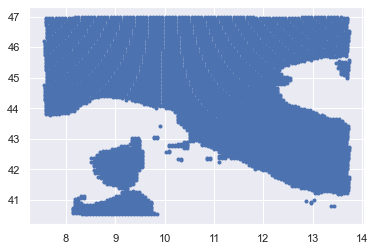

In [5]:
df_coordinates = df[df['discharge'] != 0]
df_coordinates = df.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
df_coordinates = df_coordinates.aggregate(aggregation_functions)

print('-'*40)
print(df_coordinates.head())
print('-'*40)
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.')

First of all, we need to filter North Italy coordinates only on river locations based on a proximity pattern matching where we assign the measurement of discharge to the nearest river. We filterd in the matching_points notebooks these points. So, we can associate each value with the filtered one.

In [6]:
# set the coordinates as index of the dataframe
df_drop = df.drop(columns = ['time', 'discharge', 'temp', 'prec'], inplace=False)
df['coords'] = df_drop.apply(tuple, axis=1)
df = df.set_index(['coords', 'time'])
df.tail()

lat        lon discharge  \
coords                time                                                 
(41.23425, 13.701608) 2019-12-27 12:00:00  41.23425  13.701608  1.253906   
                      2019-12-28 12:00:00  41.23425  13.701608  1.119141   
                      2019-12-29 12:00:00  41.23425  13.701608  0.998535   
                      2019-12-30 12:00:00  41.23425  13.701608  0.892578   
                      2019-12-31 12:00:00  41.23425  13.701608   0.80127   

                                               temp     prec  
coords                time                                    
(41.23425, 13.701608) 2019-12-27 12:00:00  9.257745      0.0  
                      2019-12-28 12:00:00  6.976892      0.0  
                      2019-12-29 12:00:00  9.014337      0.0  
                      2019-12-30 12:00:00  9.458612  0.00001  
                      2019-12-31 12:00:00  9.968561      0.0

[{'type': 'Feature', 'name': 'Fiume Po', 'id': 0, 'geometry': {'type': 'Point', 'coordinates': [7.6197023, 44.841927]}}, {'type': 'Feature', 'name': 'Po', 'id': 1, 'geometry': {'type': 'Point', 'coordinates': [7.673447, 45.068577]}}]


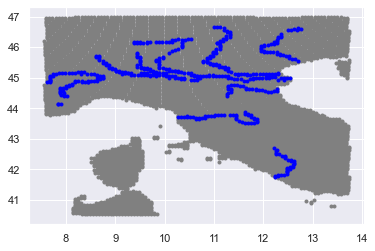

In [7]:
# filter points from original dataset to geojson coordinates related to river positions.
coords = json.load(open('../app/static/data/points.geojson', 'r'))
lats = []
longs = []
for coord in coords['features'][:]:
    sample = coord['geometry']['coordinates']
    lats.append(sample[1])
    longs.append(sample[0])

print(coords['features'][:2])
# plot coordinates
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='gray')
plt.plot(longs, lats, '.', color='blue')



The previous plot shows the interested data from the original dataset related to river discharge measurements. Actually, our dataframe contains the total amount of coordinates of the North Italy, so we need to delete coordinates by index using a patter matching between the pair of river coordinates with dataframe indices. 

In [8]:
coords_tuple = []
for i in range(len(lats)):
    coords_tuple.append(tuple([lats[i], longs[i]]))
coords_tuple[:5]

[(44.841927, 7.6197023),
 (45.068577, 7.673447),
 (45.023533, 7.6753263),
 (44.97849, 7.677202),
 (44.93344, 7.679074)]

In [9]:
rivers = pd.DataFrame()
rivers = data[data['coords'].isin(coords_tuple)]

In [10]:
rivers.head()

time        lat       lon  discharge      temp  \
18980  2011-01-01 12:00:00  44.841927  7.619702   58.29492   5.29165   
18981  2011-01-02 12:00:00  44.841927  7.619702  56.325195  4.353876   
18982  2011-01-03 12:00:00  44.841927  7.619702  54.467773  5.771906   
18983  2011-01-04 12:00:00  44.841927  7.619702  52.753906  8.080682   
18984  2011-01-05 12:00:00  44.841927  7.619702  51.195312  6.497247   

           prec                  coords  
18980       0.0  (44.841927, 7.6197023)  
18981  0.000002  (44.841927, 7.6197023)  
18982  0.000001  (44.841927, 7.6197023)  
18983       0.0  (44.841927, 7.6197023)  
18984       0.0  (44.841927, 7.6197023)

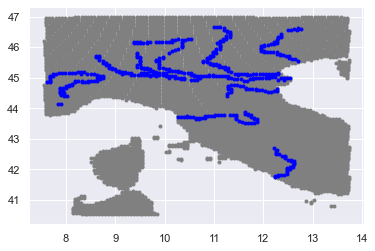

In [11]:
coords_rivers = rivers.groupby(by=["lat", "lon"], as_index=False, squeeze=True)
aggregation_functions = {'discharge': 'mean', 'temp': 'mean', 'time': 'first', 'prec' : 'mean'}
coords_rivers = coords_rivers.aggregate(aggregation_functions)
plt.plot(df_coordinates['lon'], df_coordinates['lat'], '.', color='gray')
plt.plot(coords_rivers['lon'], coords_rivers['lat'], '.', color='blue')

In [12]:
coords_rivers.head()

lat        lon   discharge       temp                 time      prec
0  41.730213  12.233403  217.905603  16.373907  2011-01-01 12:00:00  0.000021
1  41.774025  12.294938  217.534538  16.323665  2011-01-01 12:00:00  0.000021
2   41.77538  12.235047    0.408188  16.272904  2011-01-01 12:00:00  0.000020
3   41.81637  12.416491  214.655165  16.466457  2011-01-01 12:00:00  0.000023
4  41.817795  12.356562  216.510760  16.344858  2011-01-01 12:00:00  0.000022

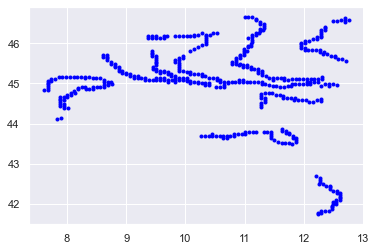

In [13]:
plt.plot(coords_rivers['lon'], coords_rivers['lat'], '.', color='blue')

The last plot shows the difference in the locations stored in the final dataset. So, we can already use data to analyze their correlation with features and past values over time. We will analyze single features and even the autocorrelation and variables correlations using different statistical tests to accept or refuse our different hypotheses on data observations. Then we can make some conclusions that may help for the modeling phase.

## Data Analysis

In this section, we will shows distributions over dataset variables on previous filtered locations. We will discover the possible seasonality, autocorrelations, correlations and hidden patterns inside the data variations over time for each of 10 selected rivers:
- Tevere: With an extension of $ 406 km $ in the Lazio region, its mount is in the Tyrrhenian Sea.
- Ticino: Its length is $ 248 km $ and it is one of the Po tributaries.
- Oglio: With an extension of $ 280 km $ is anothe Po tributary.
- Tanaro: It is a ligurian river with $ 276 km $ of length. It is also a Po tributary
- Adige: With its $ 410 km $ of length, it is the second long river of Italy, its mount is in the Adriatic sea.
- Adda: One of the main tributary of the Po river, its length is $ 313 km $.
- Piave: Born in the Alps, Piave has an extension of $ 220 km $ with the mount on the Adriatic sea.
- Po: It is the longest river in Italy, with an extension of $652 km $ and many tributaries. Its mount is also in the Adriatic sea.
- Arno: It is the main river in the Tuscany region, its length is $ 241 km $ with the mount in the Tyrrhenian Sea.
-  Reno: It is the main river in the Emilia-Romagna region, with alength of $ 212 km $ and the mount in the Adriatic Sea.



In [14]:
import json
datasource = json.load(open('../samples/source_mounth.json', 'r'))
sources_rivers = []
names = []
mounths_rivers = []
italy_sources_mounths = pd.DataFrame()
for key in datasource.keys():
    sources_rivers.append(datasource[key]['source'])
    mounths_rivers.append(datasource[key]['mounth'])
    names.append(key)

italy_sources_mounths['names'] = names
italy_sources_mounths['mounth'] = mounths_rivers
italy_sources_mounths['source'] = sources_rivers
italy_sources_mounths['number_value'] = [i for i in range(0, len(italy_sources_mounths))]
italy_sources_mounths.head()


names                  mounth                  source  number_value
0   Tanaro   [44.950962, 8.690675]   [44.12503, 7.8367176]             0
1       Po  [44.974716, 12.487255]  [44.841927, 7.6197023]             1
2  Tevere   [41.730213, 12.233403]  [42.679653, 12.207837]             2
3     Arno   [43.69623, 10.266045]  [43.864105, 11.632074]             3
4     Reno   [44.61863, 12.282794]  [44.410408, 11.271765]             4

In the previous dataframe, we collect sources and mounths coordinates related to each of the main north italy's rivers to filter time series on these points and submit tests about features analysis.

In [15]:
sources = {}
mounths = {}
names = list(italy_sources_mounths.names)
print("Time series on the following rivers: {}".format(names))
for i in range(len(italy_sources_mounths)):
    name = names[i]
    sources[name] = rivers[rivers['coords'] == tuple(italy_sources_mounths['source'][i])]
    mounths[name] = rivers[rivers['coords'] == tuple(italy_sources_mounths['mounth'][i])]


Time series on the following rivers: ['Tanaro', 'Po', 'Tevere ', 'Arno', 'Reno', 'Ticino', 'Adda', 'Oglio', 'Adige', 'Piave']


In [16]:
for name in names:
    df = sources[name]
    df2 = mounths[name]
    df.index = sources[name]['time']
    df2.index = mounths[name]['time']
    df.drop(columns=['time'], inplace=True)
    df2.drop(columns=['time'], inplace=True)
    sources[name] = df
print(sources['Po'].head())
print('-'*40)
print(mounths['Po'].head())

                           lat       lon  discharge      temp      prec  \
time                                                                      
2011-01-01 12:00:00  44.841927  7.619702   58.29492   5.29165       0.0   
2011-01-02 12:00:00  44.841927  7.619702  56.325195  4.353876  0.000002   
2011-01-03 12:00:00  44.841927  7.619702  54.467773  5.771906  0.000001   
2011-01-04 12:00:00  44.841927  7.619702  52.753906  8.080682       0.0   
2011-01-05 12:00:00  44.841927  7.619702  51.195312  6.497247       0.0   

                                     coords  
time                                         
2011-01-01 12:00:00  (44.841927, 7.6197023)  
2011-01-02 12:00:00  (44.841927, 7.6197023)  
2011-01-03 12:00:00  (44.841927, 7.6197023)  
2011-01-04 12:00:00  (44.841927, 7.6197023)  
2011-01-05 12:00:00  (44.841927, 7.6197023)  
----------------------------------------
                           lat        lon  discharge      temp      prec  \
time                               

Sources and mounths contains the time series related to the source and mounths points chosen by each north italian rivers. Given an statistical hypothesis, this collection is used to verify some properties for different italian rivers. So, we will analyze in the sections below variations on discharges, temperatures and precipitations and, finally, we concludes with some observations and related tests on the correlations and autocorrelations between their values.

### Discharge Variations

In [17]:
rivers.describe()

time           lat           lon     discharge  \
count               1518594  1.518594e+06  1.518594e+06  1.518594e+06   
unique                 3287  4.620000e+02  4.620000e+02  6.915260e+05   
top     2011-01-01 12:00:00  4.484193e+01  7.619702e+00  6.054688e-02   
freq                    462  3.287000e+03  3.287000e+03  3.110000e+02   

                temp       prec                  coords  
count   1.518594e+06  1518594.0                 1518594  
unique  8.026990e+05  1442014.0                     462  
top     1.310104e+01        0.0  (44.841927, 7.6197023)  
freq    1.200000e+01    72747.0                    3287

In [18]:
np.asarray(rivers['coords'])

array([(44.841927, 7.6197023), (44.841927, 7.6197023),
       (44.841927, 7.6197023), ..., (42.082775, 12.607817),
       (42.082775, 12.607817), (42.082775, 12.607817)], dtype=object)

In [130]:
colors = ["b", "g", "r", "c", "m", "y", "b", "g", "r", "c", "m"]

10

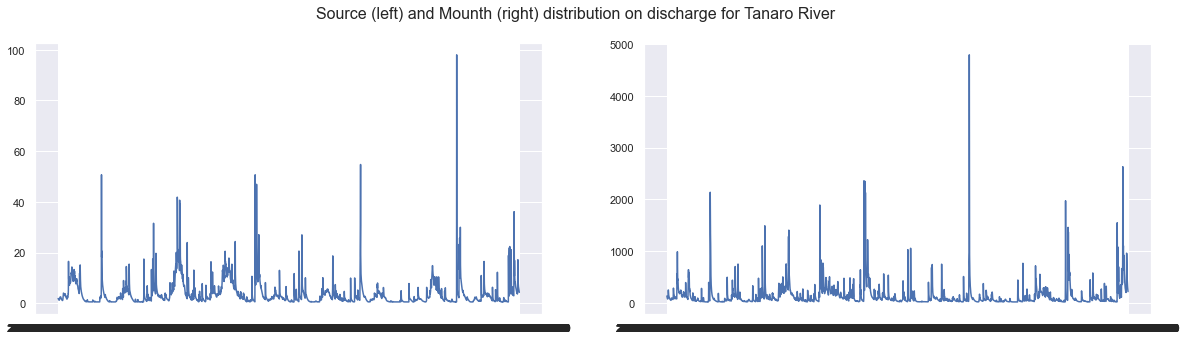

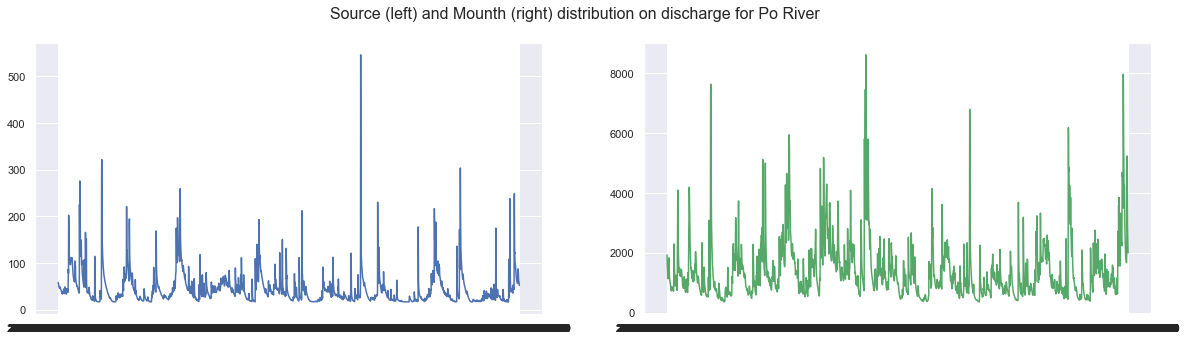

KeyboardInterrupt: 

In [132]:
%%time
def plot_series(key, type, color):
    figure, axis = plt.subplots(1, 2)
    figure.set_size_inches(20,5)
    figure.suptitle('Source (left) and Mounth (right) distributions on {} for {} River'.format(type, key), fontsize=16)
    axis[0].plot(sources[key][type], label=key)
    axis[1].plot(mounths[key][type], label=key)
    plt.gca().get_lines()[0].set_color(color)
    plt.show()

i = 0
colors = ["b", "g", "r", "c", "m", "y", "b", "g", "r", "c", "m"]
for key in sources.keys():
    plot_series(key, 'discharge', colors[i])
    i = i + 1


In [19]:
print('North Italy River Discharges Info: ')
print('-'*40)
print('Maximum River Discharge: {}'.format(rivers['discharge'].max()))
print('Minimum River Discharge: {}'.format(rivers['discharge'].min()))
print('Mean River Discharge: {}'.format(rivers['discharge'].mean()))
print('-'*40)
max_coord = rivers[rivers['discharge'] == rivers['discharge'].max()].coords
min_coord = rivers[rivers['discharge'] == rivers['discharge'].min()].coords
print('Coordinates of the the maximum discharge: \n{}'.format(max_coord))
print('Coordinates of the the minimum discharge: \n{}'.format(min_coord))
print('-'*40)

for coord in coords['features'][:]:
    # checks the name associated to the coordinates
    # change latitude and longitude values 
    lat = coord['geometry']['coordinates'][1]
    lon = coord['geometry']['coordinates'][0]
    latlon = [lat, lon]
    
    if(latlon == list(np.asarray(max_coord)[0])):
        print('River with the maximum discharge: {}'.format(coord['name']))
    if(latlon == list(np.asarray(min_coord)[0])):
        print('River with minimum discharge: {}'.format(coord['name']))


North Italy River Discharges Info: 
----------------------------------------
Maximum River Discharge: 9156.398
Minimum River Discharge: 1.7401733e-14
Mean River Discharge: 250.5543845591428
----------------------------------------
Coordinates of the the maximum discharge: 
1685890    (45.0442, 11.032715)
Name: coords, dtype: object
Coordinates of the the minimum discharge: 
1696062    (43.781845, 11.010019)
Name: coords, dtype: object
----------------------------------------
River with the maximum discharge: Fiume Po
River with minimum discharge: Arno


Discharge value represents the volume rate of water flow, including sediments, chemical and biological material, in the river channel averaged over a time step through a cross-section. The value is an average over each 6-hour time step. So, the maximum and minimum are relative to 6 hours variation. Coordinates related to the maximum dicharge is related to the Po river on the outfall area, meanwhile the minimum discharge value is in the river source of the Arno (Emilia-Romagna). Our measurements considers a value every 2.5 km between two points of a river, with a temporal approximation of 6 hours. North Italy rivers has similar features about the yearly climate variation. However, some locations can have different behavior in relation to external factors like precipitations or temperatures.


In [20]:
rivers['time'] = pd.to_datetime(rivers['time'], format = '%Y-%m-%d %H:%M:%S')
max_river = rivers.set_index('time')
max_river = max_river[max_river['lat'] == np.asarray(max_coord)[0][0]]
max_river = max_river[max_river['lon'] == np.asarray(max_coord)[0][1]]

min_river = rivers.set_index('time')
min_river = min_river[min_river['lat'] == np.asarray(min_coord)[0][0]]
min_river = min_river[min_river['lon'] == np.asarray(min_coord)[0][1]]

print(max_river.tail())
print('-'*40)
print(min_river.tail())


                         lat        lon  discharge      temp      prec  \
time                                                                     
2019-12-27 12:00:00  45.0442  11.032715    2558.58  2.561151       0.0   
2019-12-28 12:00:00  45.0442  11.032715  2317.5894  1.179773       0.0   
2019-12-29 12:00:00  45.0442  11.032715  2110.4243  4.203943  0.000001   
2019-12-30 12:00:00  45.0442  11.032715  1935.3901  6.152856       0.0   
2019-12-31 12:00:00  45.0442  11.032715  1789.1885  5.303918       0.0   

                                   coords  
time                                       
2019-12-27 12:00:00  (45.0442, 11.032715)  
2019-12-28 12:00:00  (45.0442, 11.032715)  
2019-12-29 12:00:00  (45.0442, 11.032715)  
2019-12-30 12:00:00  (45.0442, 11.032715)  
2019-12-31 12:00:00  (45.0442, 11.032715)  
----------------------------------------
                           lat        lon discharge      temp      prec  \
time                                                     

In [21]:
# division of time series between years
years = [i for i in range(2011,2020)]
times_series_max = []
times_series_min = []
for year in years:
    times_series_max.append(max_river.loc['{}-01-01'.format(year):'{}-01-01'.format(year+1)])
    times_series_min.append(max_river.loc['{}-01-01'.format(year):'{}-01-01'.format(year+1)])
print(times_series_max[8].tail())
print('-'*40)
print(times_series_min[8].tail())


                         lat        lon  discharge      temp      prec  \
time                                                                     
2019-12-27 12:00:00  45.0442  11.032715    2558.58  2.561151       0.0   
2019-12-28 12:00:00  45.0442  11.032715  2317.5894  1.179773       0.0   
2019-12-29 12:00:00  45.0442  11.032715  2110.4243  4.203943  0.000001   
2019-12-30 12:00:00  45.0442  11.032715  1935.3901  6.152856       0.0   
2019-12-31 12:00:00  45.0442  11.032715  1789.1885  5.303918       0.0   

                                   coords  
time                                       
2019-12-27 12:00:00  (45.0442, 11.032715)  
2019-12-28 12:00:00  (45.0442, 11.032715)  
2019-12-29 12:00:00  (45.0442, 11.032715)  
2019-12-30 12:00:00  (45.0442, 11.032715)  
2019-12-31 12:00:00  (45.0442, 11.032715)  
----------------------------------------
                         lat        lon  discharge      temp      prec  \
time                                                      

### Seasonal Decomposition

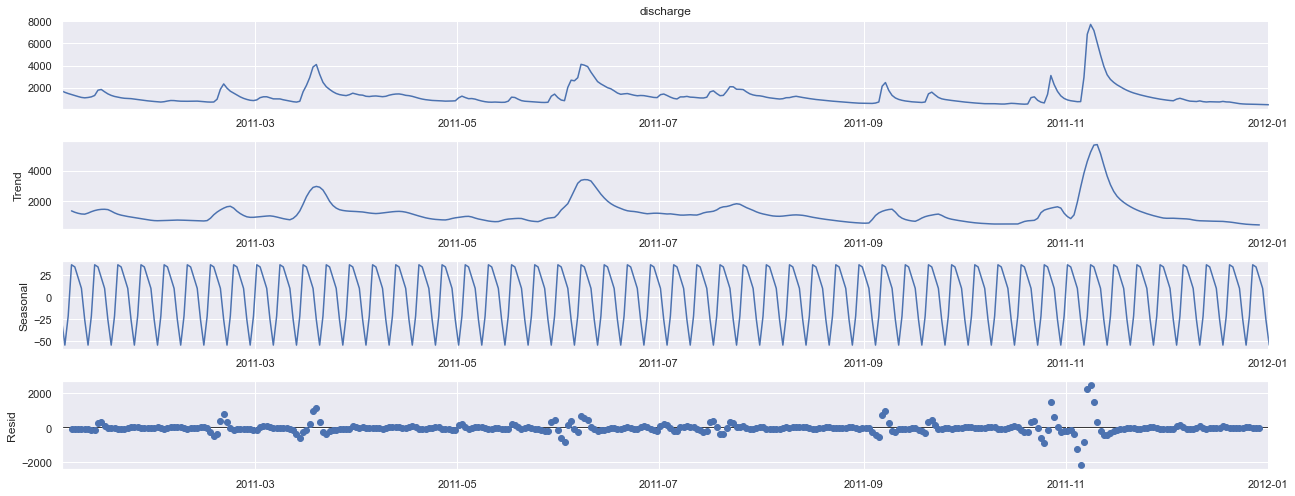

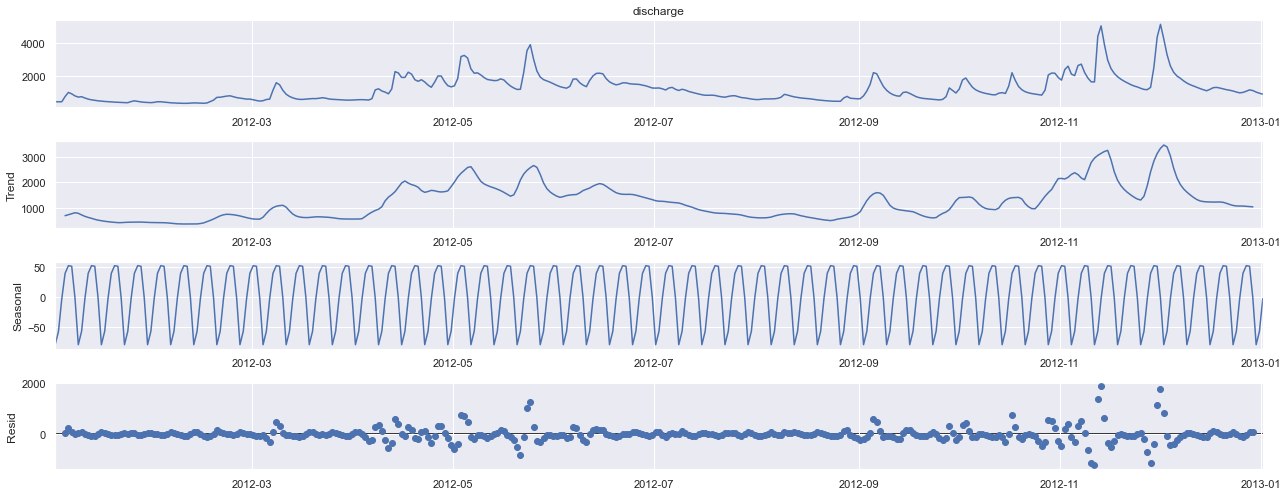

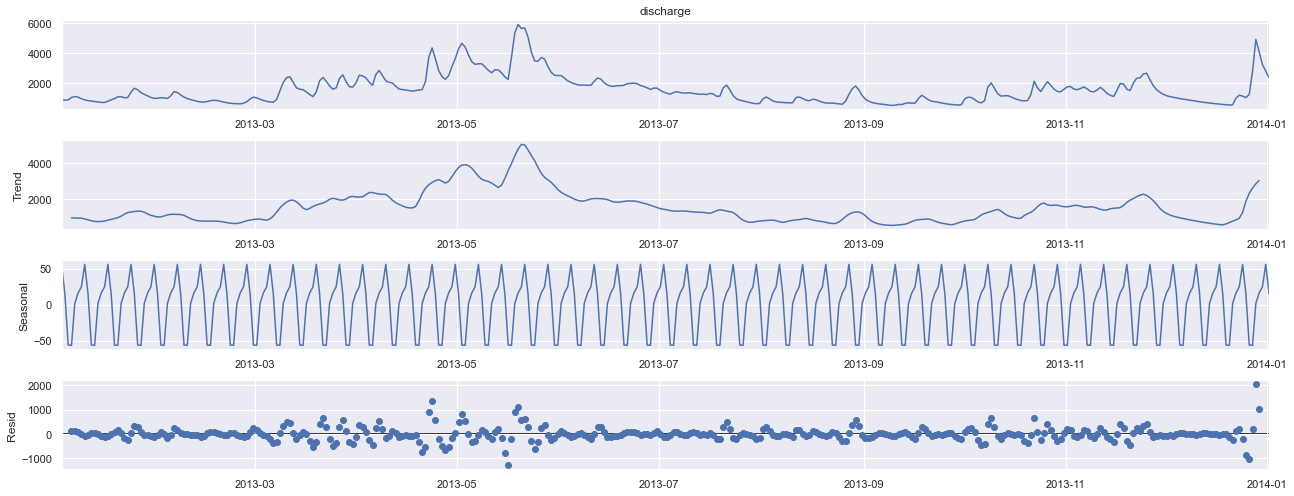

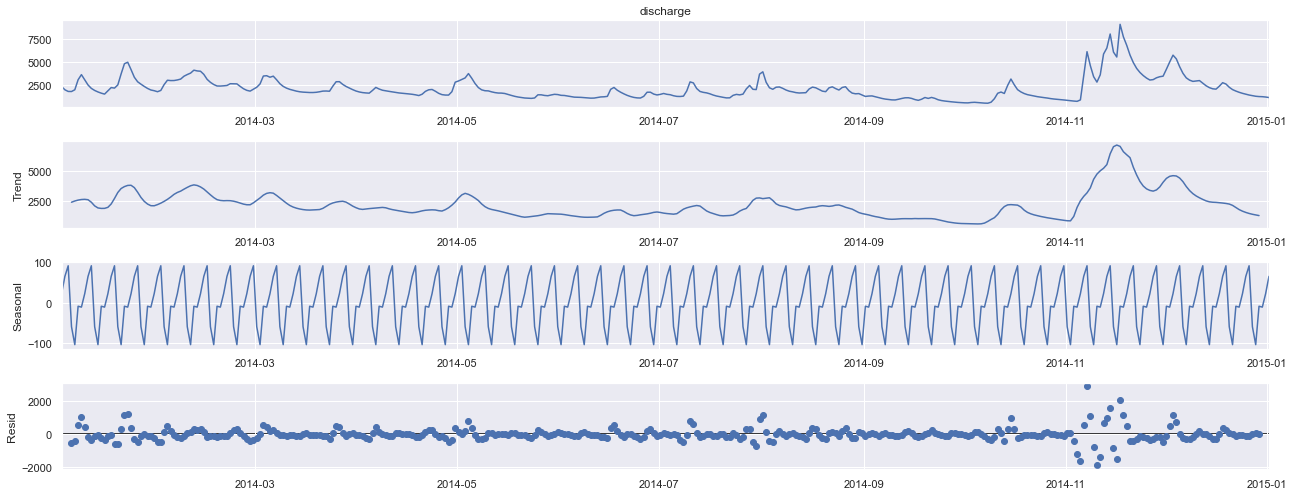

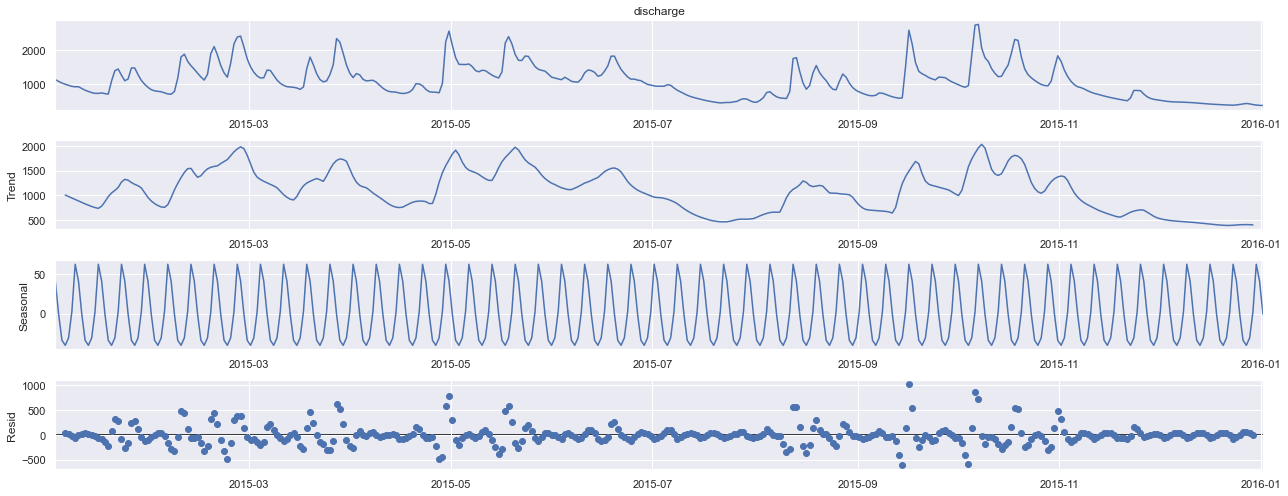

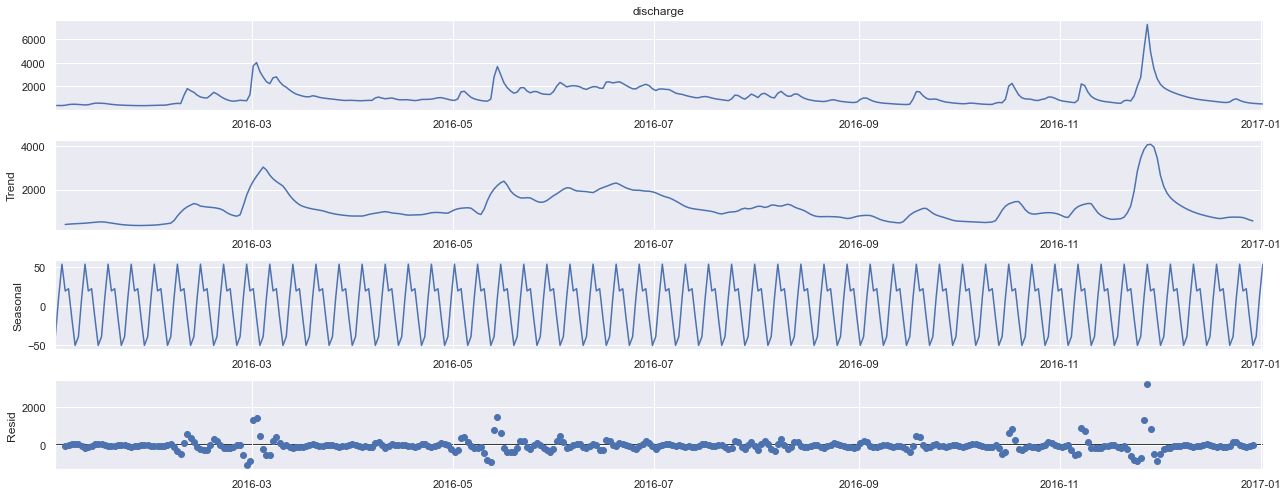

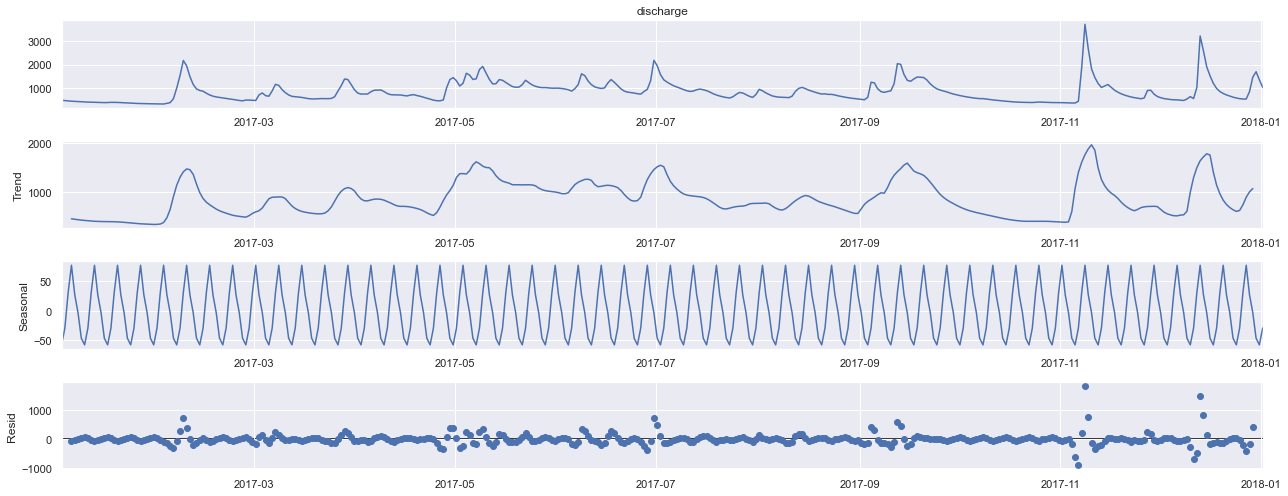

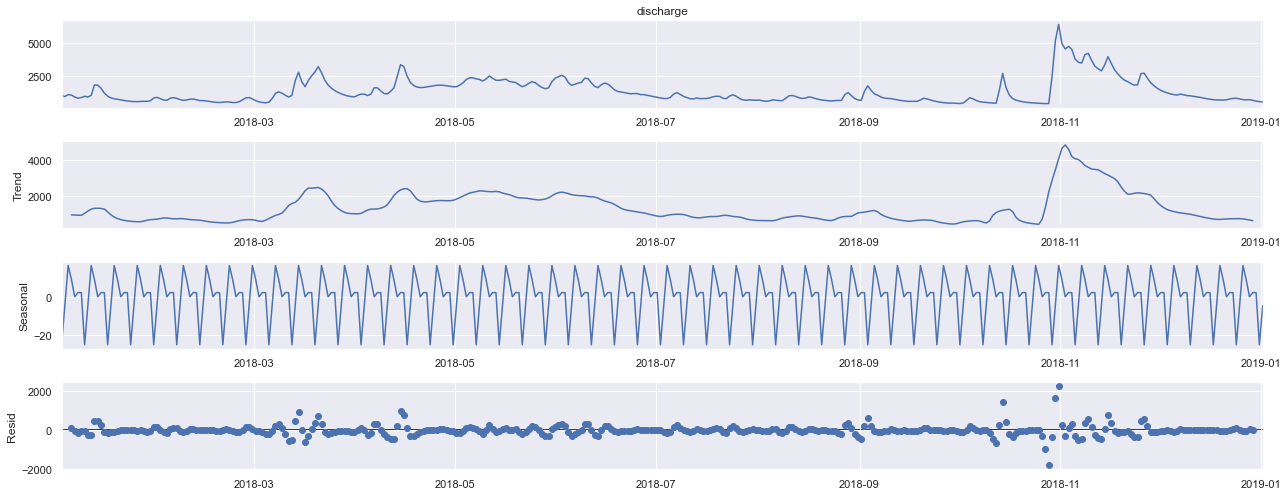

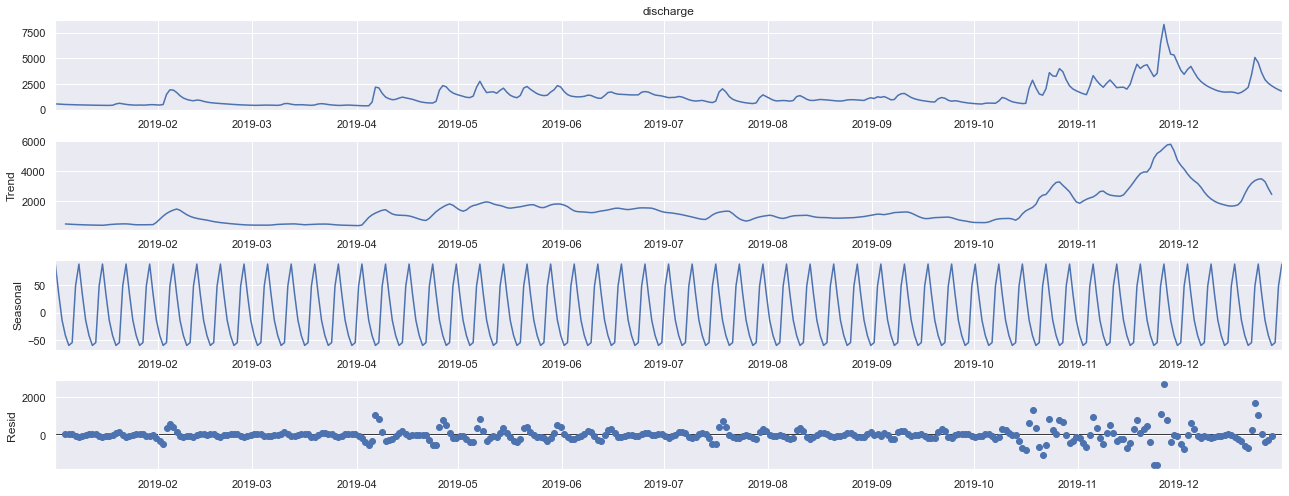

In [22]:
trends = []
residuals = []
seasonals = []
for i in range(len(years)):

    river_max = times_series_max[i]
    analysis = river_max['discharge'].copy()

    decompose_result_mult = seasonal_decompose(analysis, model="additive")

    trends.append(decompose_result_mult.trend)
    seasonals.append(decompose_result_mult.seasonal)
    residuals.append(decompose_result_mult.resid)


    fig = decompose_result_mult.plot()
    fig.set_size_inches((18, 7))
    # Tight layout to realign things
    fig.tight_layout()
plt.show()

- The trend component is supposed to capture the slowly-moving overall level of the series.
- The seasonal component captures patterns that repeat every season.
- The residual is what is left. It may or may not be autocorrelated.

Graphically, we can see how the trends increase in the last period of most considered years (around November and December). Seasonals have similar frequencies between years with a minimum variation. Trends are never regular because external factors, seasons, and environmental changes can drastically influence the increment or decrement of the mean daily discharge. 

In [23]:
size = trends[0]

In [24]:
discharge_mean = []
for j in range(len(trends[0])):
    sum = 0
    for i in range(len(years)):
        d = np.asarray(rivers['discharge'])[(j)*(i+1)]
        sum += d

    mean = sum / len(years)
    discharge_mean.append(mean)


df_mean = pd.DataFrame()
df_mean.index = trends[0].index
df_mean['discharge'] = discharge_mean

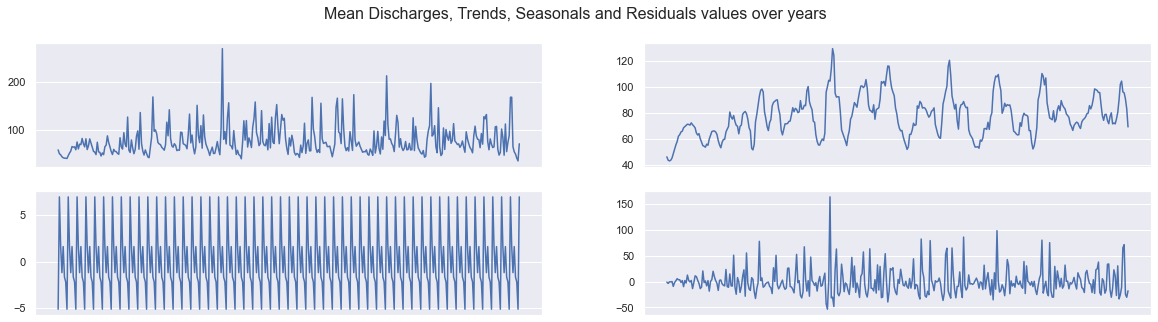

In [25]:
analysis = df_mean['discharge'].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend_mean = decompose_result_mult.trend
seasonal_mean = decompose_result_mult.seasonal
residuals_mean = decompose_result_mult.resid

figure, axis = plt.subplots(2, 2)
figure.set_size_inches(20,5)
figure.suptitle('Mean Discharges, Trends, Seasonals and Residuals values over years', fontsize=16)
axis[0,0].plot(df_mean)
axis[0,1].plot(trend_mean)
axis[1,0].plot(seasonal_mean)
axis[1,1].plot(residuals_mean)
axis[0,0].set_xticks([])
axis[0,1].set_xticks([])
axis[1,0].set_xticks([])
axis[1,1].set_xticks([])

plt.show()

The figure above shows, in order, the mean changing on discharges, trends, seasonals and residuals values. Trends continues to be irregular due to the variability over years. We will define in the next section ADF and KPSS to determinate if these time series are stationary or not. This observation will be useful during the modelling phase. In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

## Temperatures Variations

In [28]:
print('North Italy River Temperatures Info: ')
print('-'*40)
print('Maximum River Temperature: {}'.format(rivers['temp'].max()))
print('Minimum River Temperature: {}'.format(rivers['temp'].min()))
print('Mean River Temperature: {}'.format(rivers['temp'].mean()))
print('-'*40)
max_coord = rivers[rivers['temp'] == rivers['temp'].max()].coords
min_coord = rivers[rivers['temp'] == rivers['temp'].min()].coords
print('Coordinates of the the maximum Temperature: \n{}'.format(max_coord))
print('Coordinates of the the minimum Temperature: \n{}'.format(min_coord))
print('-'*40)

for coord in coords['features'][:]:
    # checks the name associated to the coordinates
    # change latitude and longitude values 
    lat = coord['geometry']['coordinates'][1]
    lon = coord['geometry']['coordinates'][0]
    latlon = [lat, lon]
    
    if(latlon == list(np.asarray(max_coord)[0])):
        print('River with the maximum Temperature: {}'.format(coord['name']))
    if(latlon == list(np.asarray(min_coord)[0])):
        print('River with minimum Temperature: {}'.format(coord['name']))


North Italy River Temperatures Info: 
----------------------------------------
Maximum River Temperature: 33.5550476074219
Minimum River Temperature: -20.383825683593727
Mean River Temperature: 13.465150697467763
----------------------------------------
Coordinates of the the maximum Temperature: 
2419822    (44.57493, 12.218169)
Name: coords, dtype: object
Coordinates of the the minimum Temperature: 
2635918    (46.63714, 12.694899)
Name: coords, dtype: object
----------------------------------------
River with the maximum Temperature: Fiume Reno
River with minimum Temperature: Piave


The minimum temperature is on the Piave source on the Alps where the temperature. Meanwhile, the highest one is on the Reno in the Emilia-Romagna. 

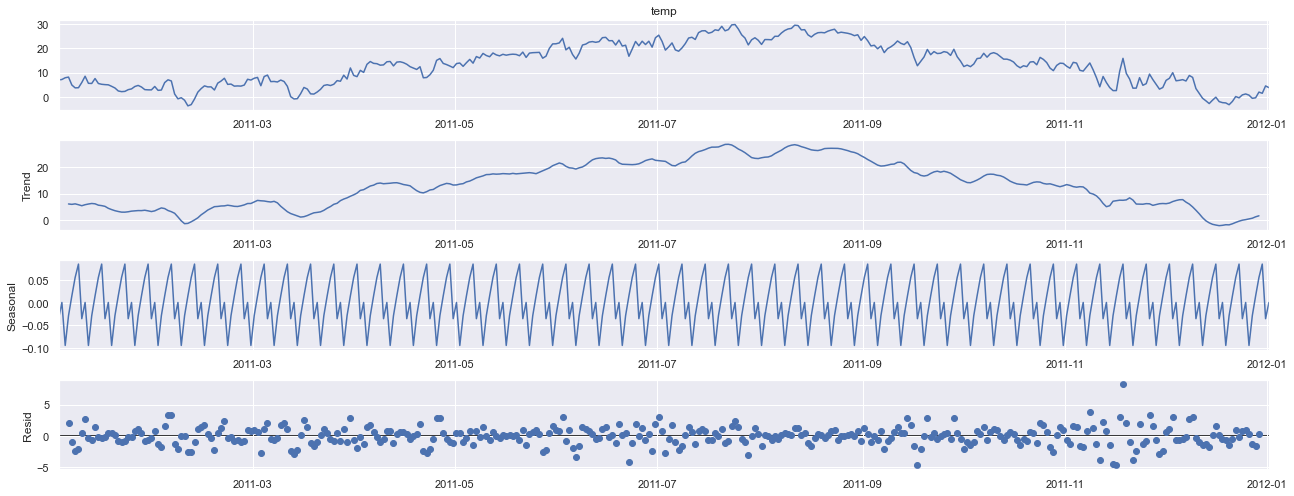

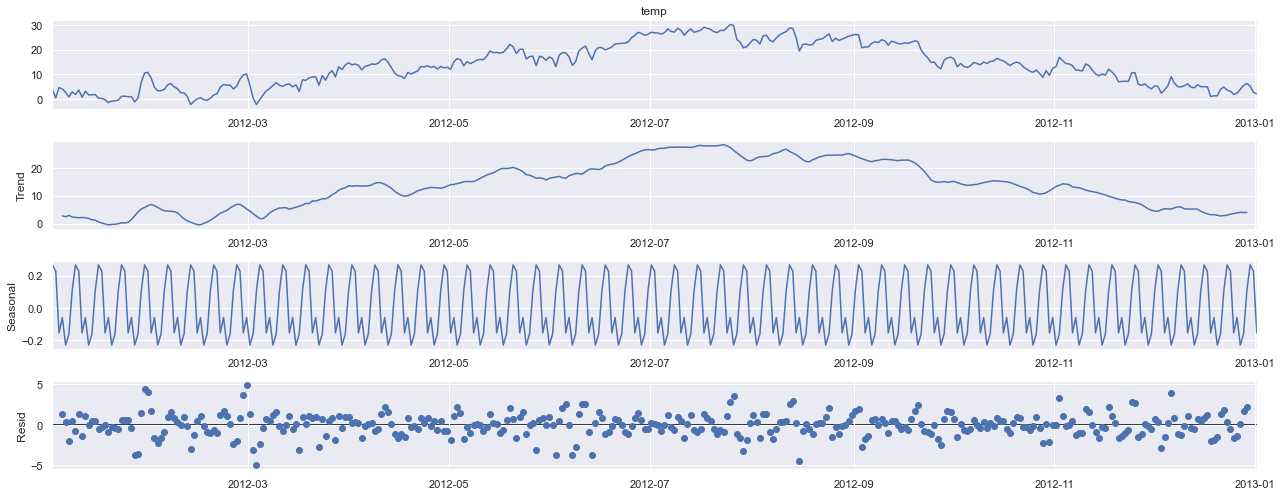

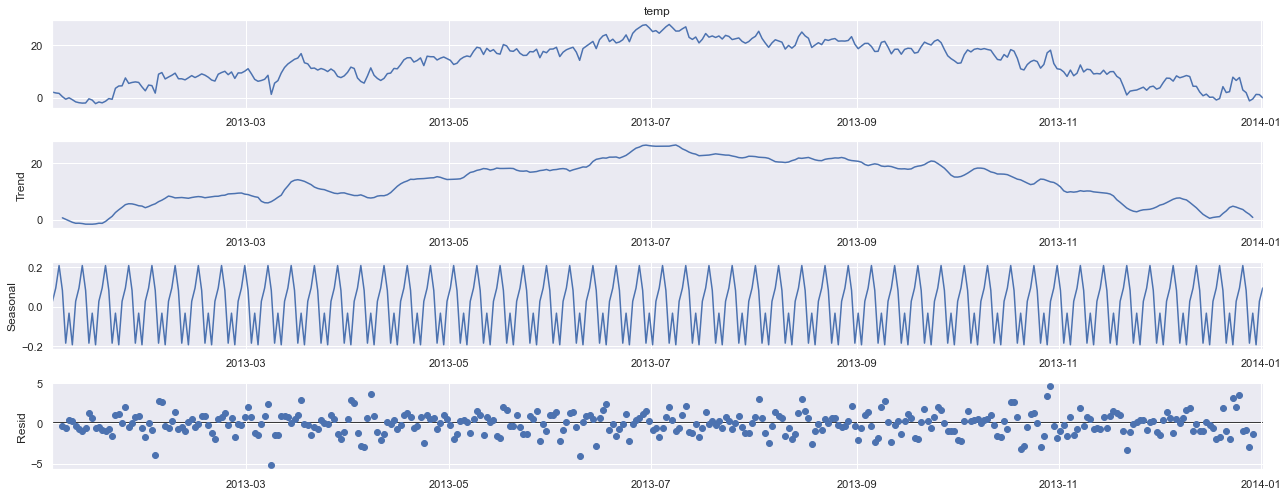

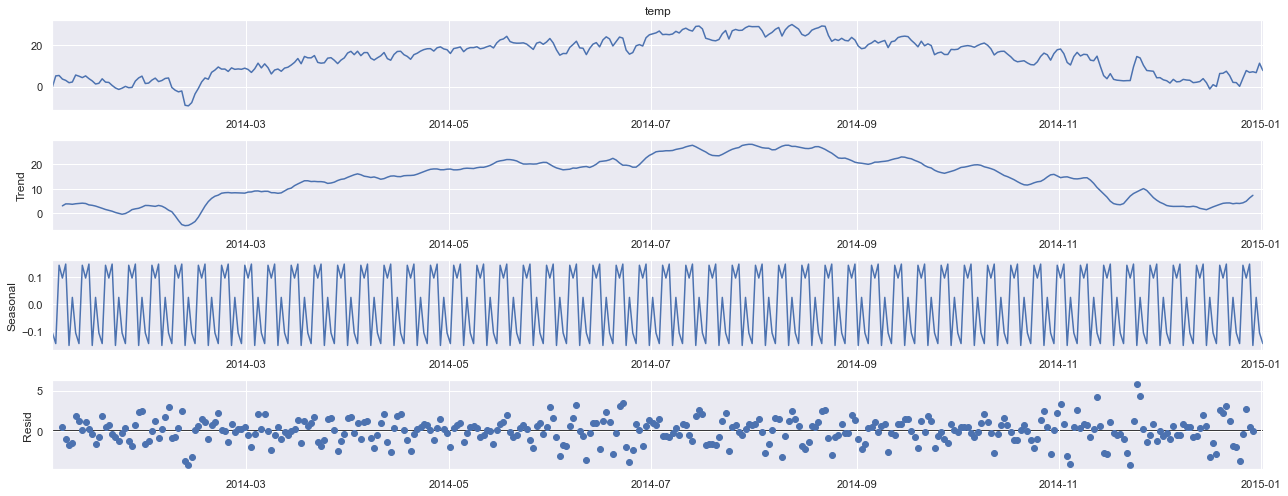

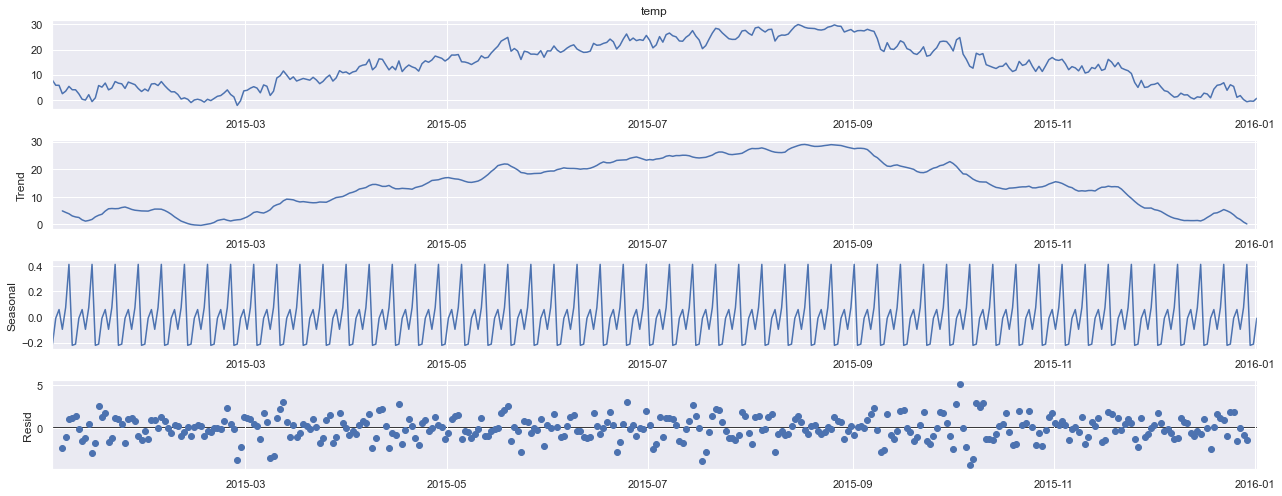

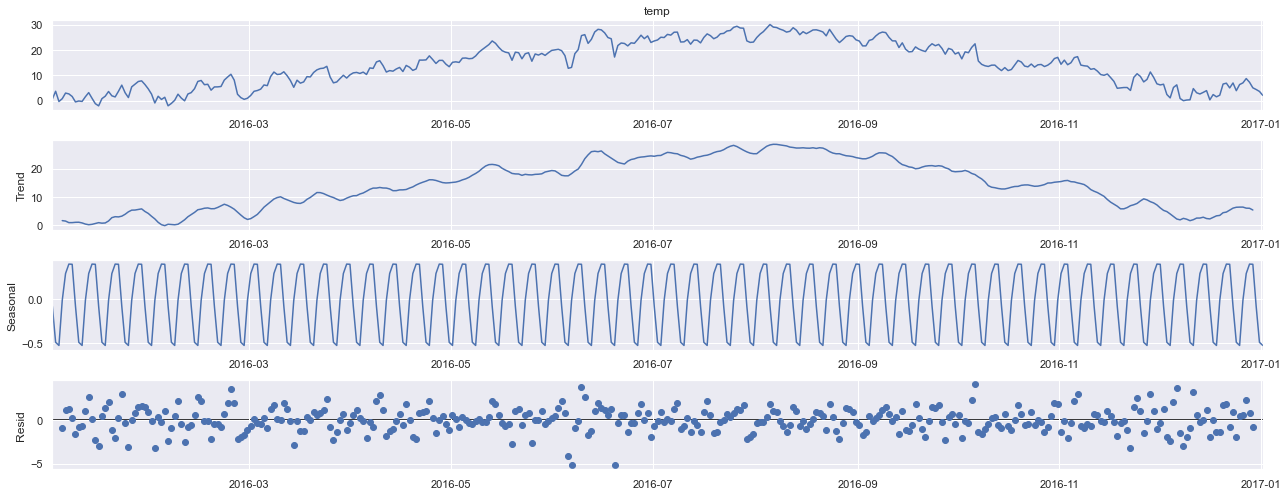

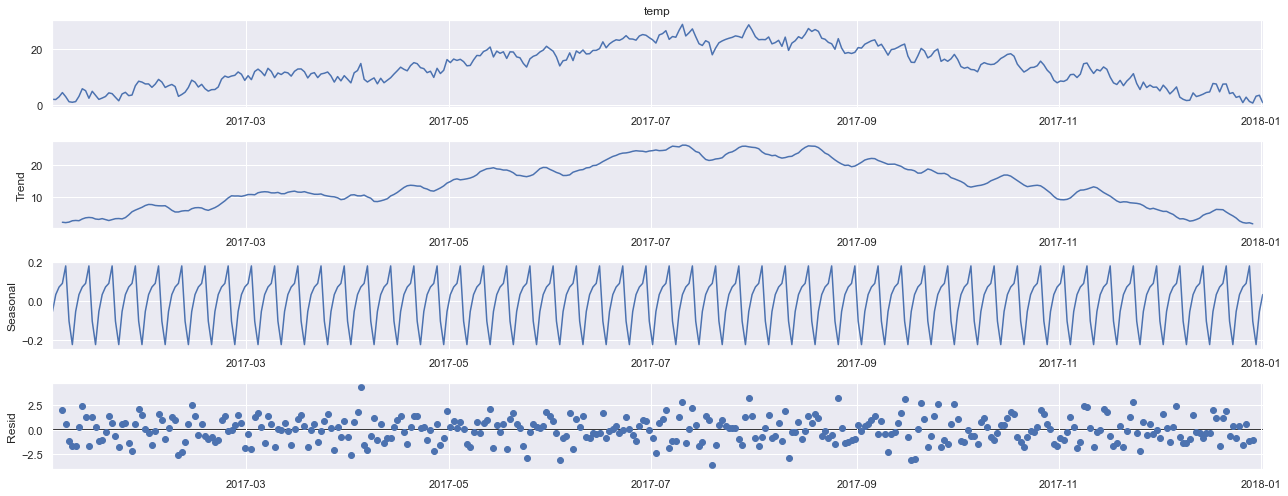

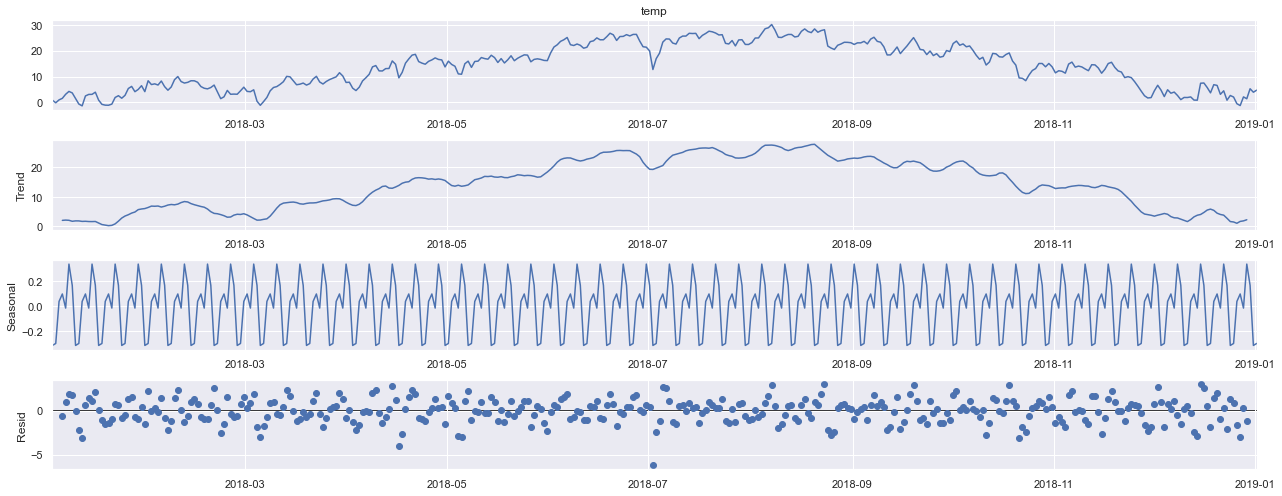

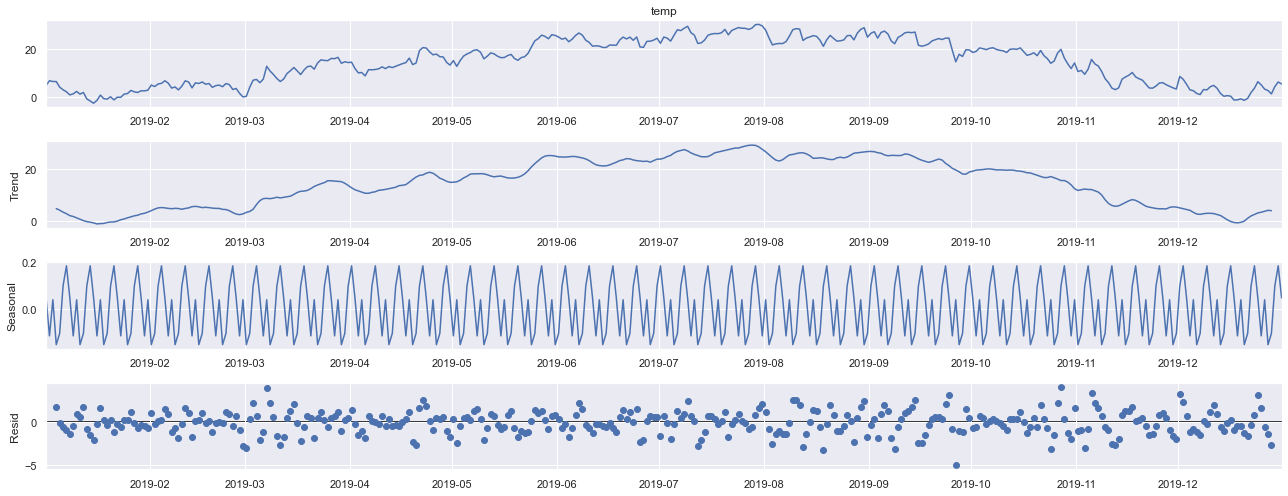

In [29]:
trends = []
residuals = []
seasonals = []
for i in range(len(years)):

    river_max = times_series_max[i]
    analysis = river_max['temp'].copy()

    decompose_result_mult = seasonal_decompose(analysis, model="additive")

    trends.append(decompose_result_mult.trend)
    seasonals.append(decompose_result_mult.seasonal)
    residuals.append(decompose_result_mult.resid)


    fig = decompose_result_mult.plot()
    fig.set_size_inches((18, 7))
    # Tight layout to realign things
    fig.tight_layout()
plt.show()

In [61]:
temp_mean = []
for j in range(len(trends[0])):
    sum = 0
    for i in range(len(years)):
        d = np.asarray(rivers['temp'])[(j)*(i+1)]
        sum += d

    mean = sum / len(years)
    temp_mean.append(mean)


df_mean = pd.DataFrame()
df_mean.index = trends[0].index
df_mean['temp'] = temp_mean

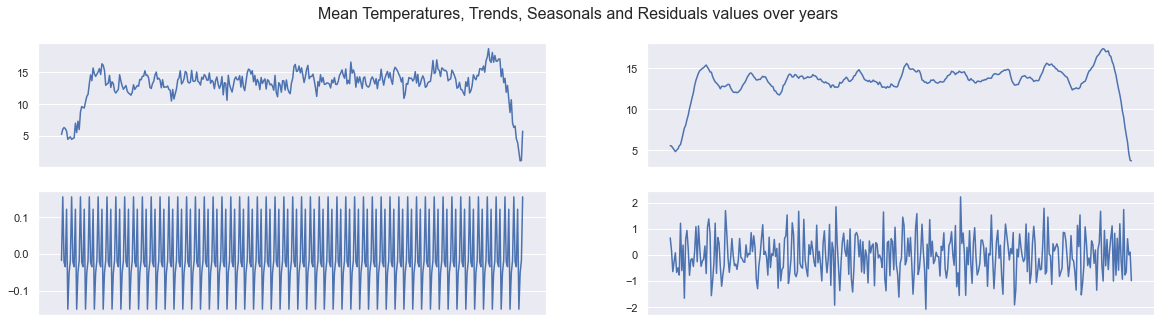

In [62]:
analysis = df_mean['temp'].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend_mean = decompose_result_mult.trend
seasonal_mean = decompose_result_mult.seasonal
residuals_mean = decompose_result_mult.resid

figure, axis = plt.subplots(2, 2)
figure.set_size_inches(20,5)
figure.suptitle('Mean Temperatures, Trends, Seasonals and Residuals values over years', fontsize=16)
axis[0,0].plot(df_mean)
axis[0,1].plot(trend_mean)
axis[1,0].plot(seasonal_mean)
axis[1,1].plot(residuals_mean)
axis[0,0].set_xticks([])
axis[0,1].set_xticks([])
axis[1,0].set_xticks([])
axis[1,1].set_xticks([])

plt.show()

We know that temperatures focus the seasonality over years with local maxima in the summer and local minima in the winter on the North of Italy. We can see how the mean trend is lower on the winter months but is similar for other seasons. The location analyzed before is related to the Po mounths, where the sea level and constant adriatic winds can mitigate the temperature variation during spring and autumnal period.

## Precipitations Variations

In [54]:
print('North Italy River Precipitations Info: ')
print('-'*40)
print('Maximum River Precipitation: {}'.format(rivers['prec'].max()))
print('Minimum River Precipitation: {}'.format(rivers['prec'].min()))
print('Mean River Precipitation: {}'.format(rivers['prec'].mean()))
print('-'*40)

for coord in coords['features'][:]:
    # checks the name associated to the coordinates
    # change latitude and longitude values 
    lat = coord['geometry']['coordinates'][1]
    lon = coord['geometry']['coordinates'][0]
    latlon = [lat, lon]

North Italy River Precipitations Info: 
----------------------------------------
Maximum River Precipitation: 0.004765448
Minimum River Precipitation: 0.0
Mean River Precipitation: 2.620589137734672e-05
----------------------------------------


Precipitations have irregular distribution given by the seasons, area of interests and temperatures influence but also data not available like humidity of the air. In any case, we can consider it as a variable that could be cause a variation on the discharge of a given river. This test will be consider in the next sections. Now, we consider how the distribution is in different years and if it has a regular trends that may have some hidden information with interesting data.

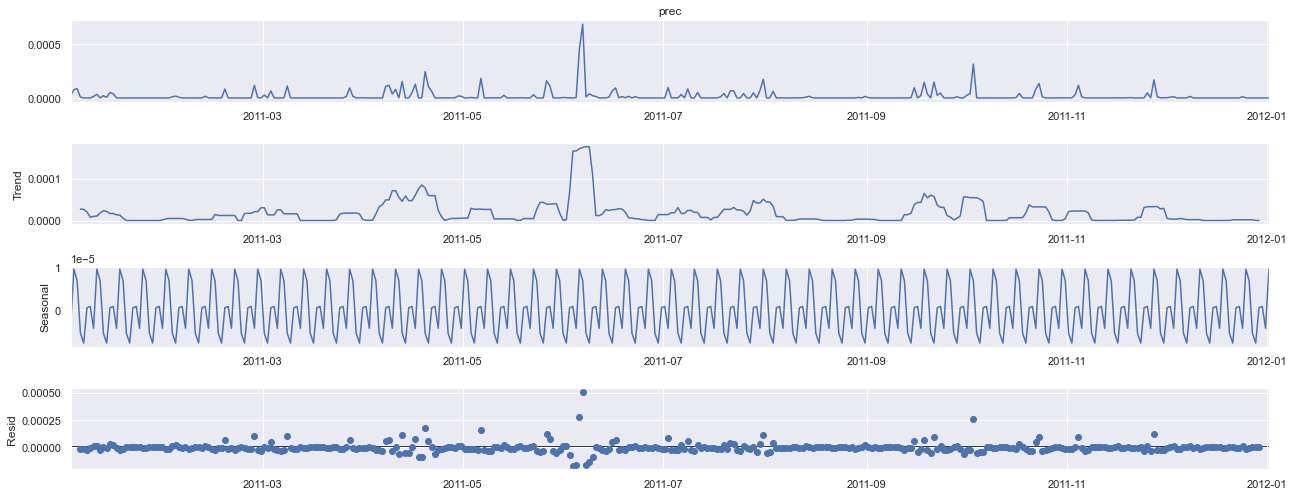

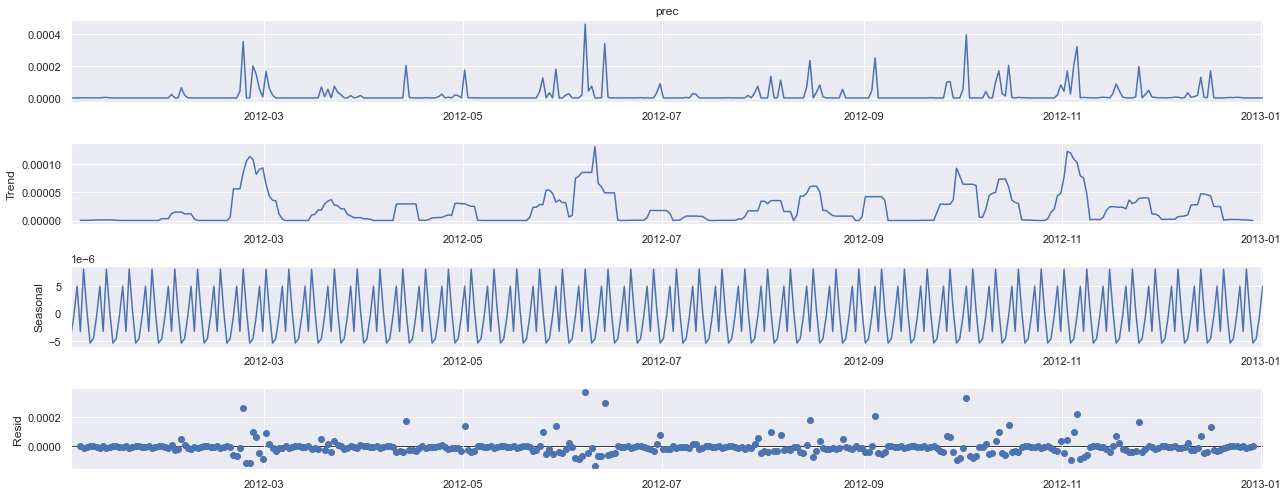

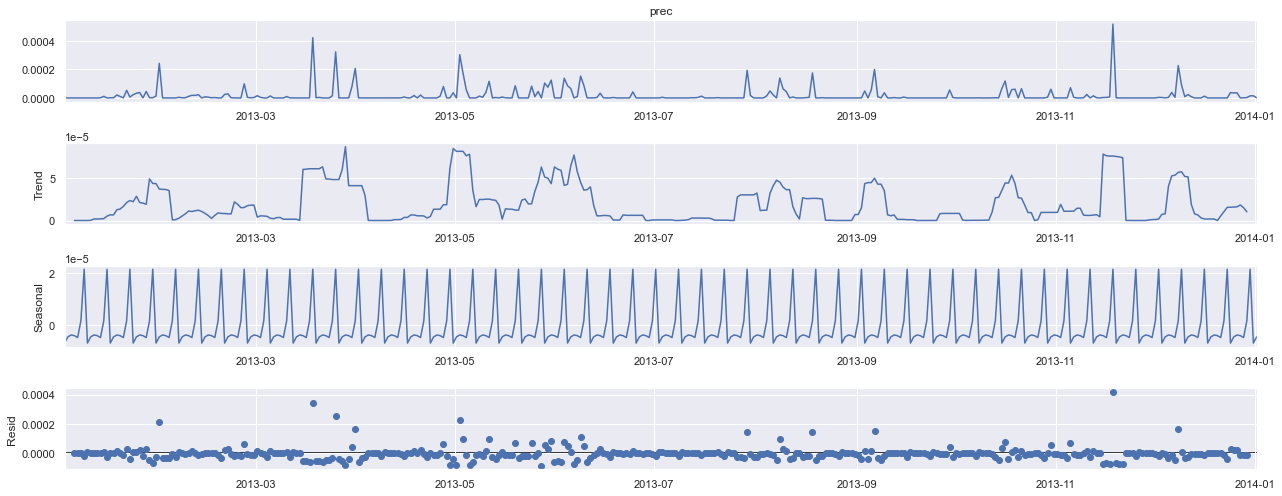

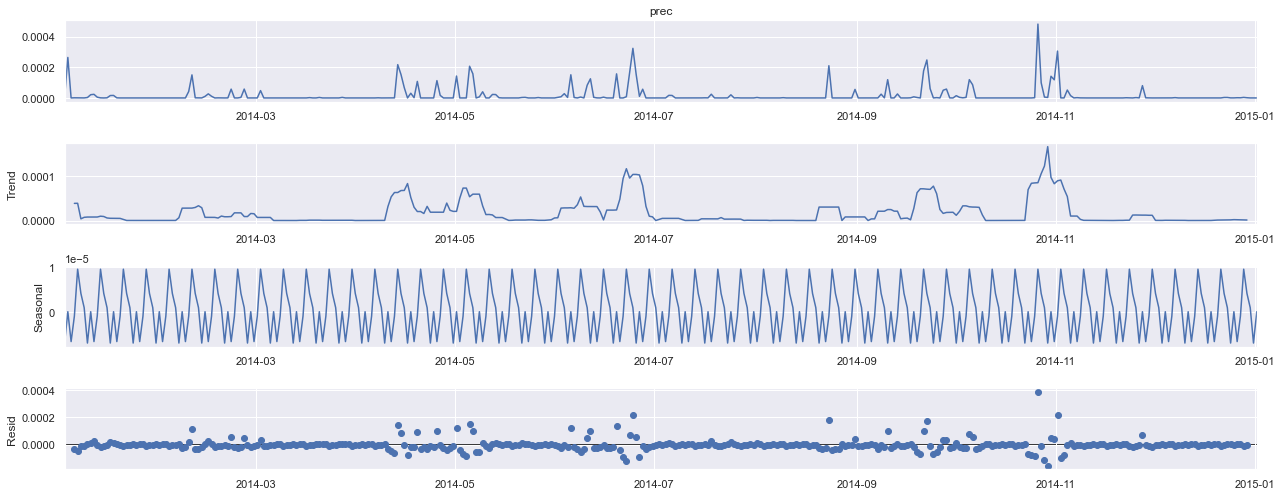

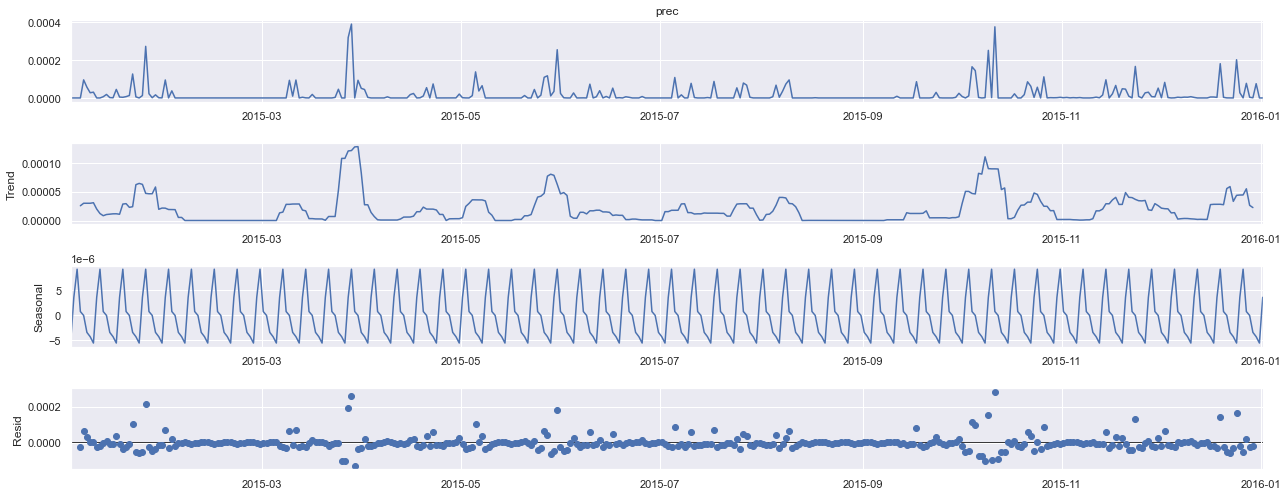

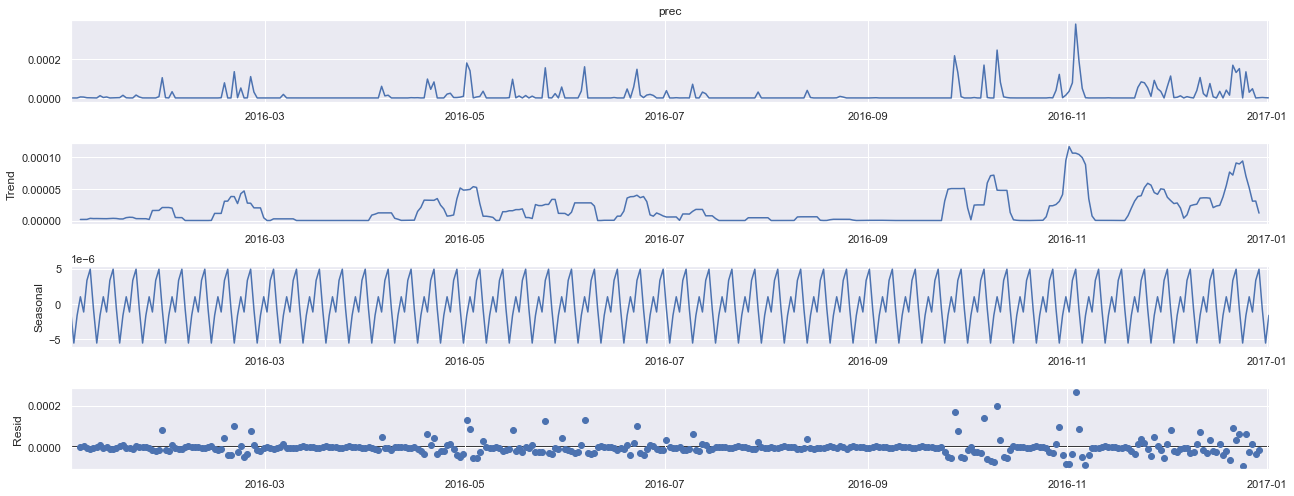

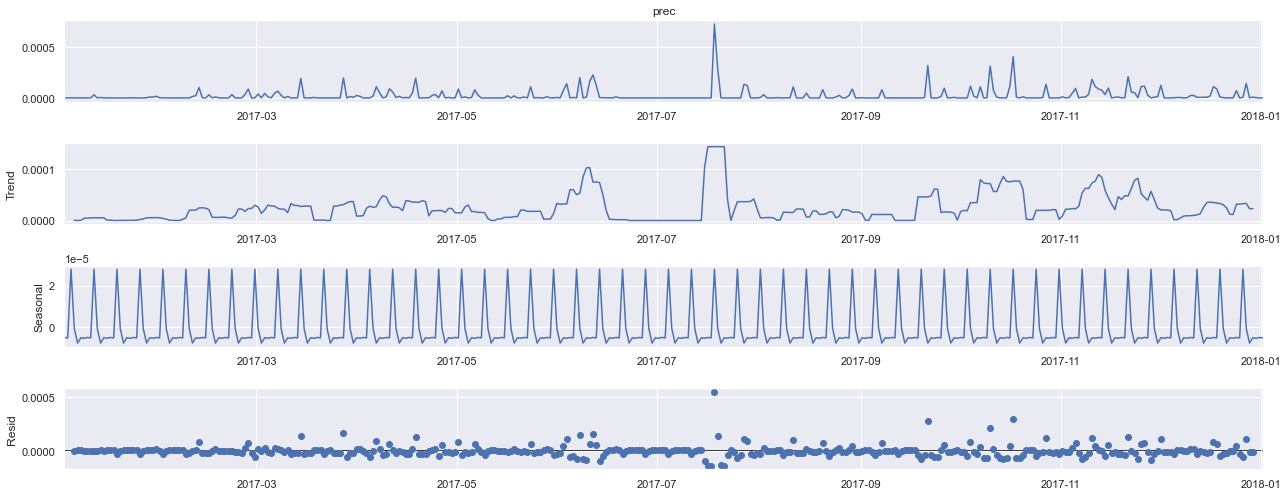

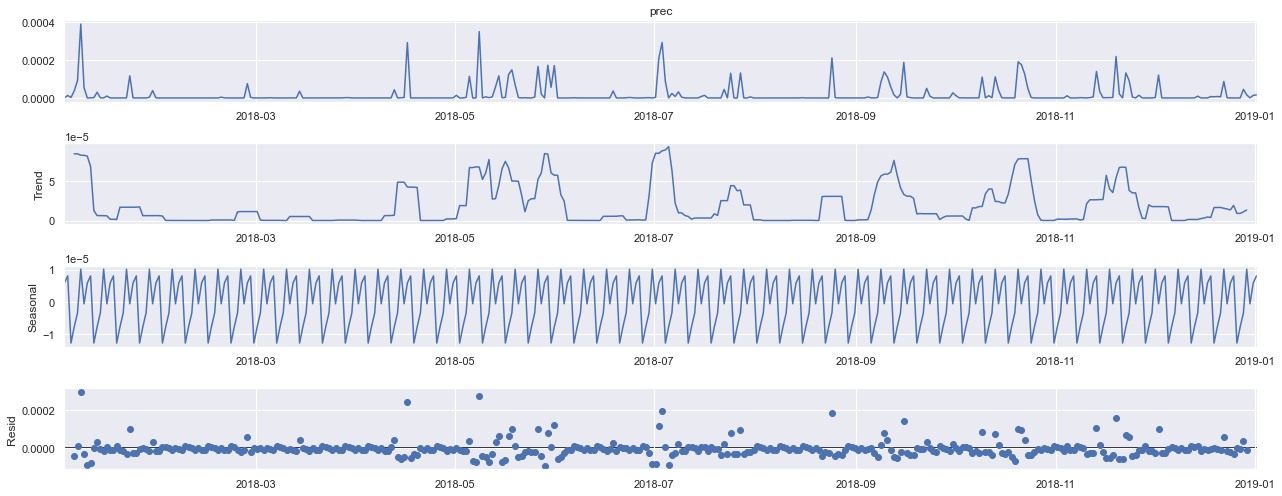

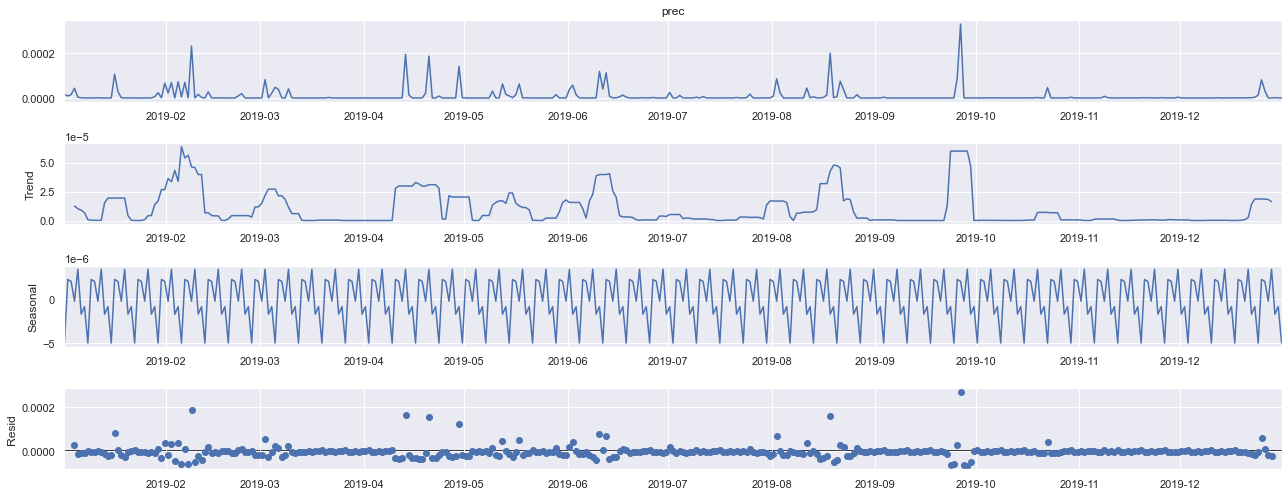

In [55]:
trends = []
residuals = []
seasonals = []
for i in range(len(years)):

    river_max = times_series_max[i]
    analysis = river_max['prec'].copy()

    decompose_result_mult = seasonal_decompose(analysis, model="additive")

    trends.append(decompose_result_mult.trend)
    seasonals.append(decompose_result_mult.seasonal)
    residuals.append(decompose_result_mult.resid)


    fig = decompose_result_mult.plot()
    fig.set_size_inches((18, 7))
    # Tight layout to realign things
    fig.tight_layout()
plt.show()

In our main location of interest (the mounth of the Po river), we can say that precipitations has different pitches distribution over years.

In [56]:
prec_mean = []
for j in range(len(trends[0])):
    sum = 0
    for i in range(len(years)):
        d = np.asarray(rivers['prec'])[(j)*(i+1)]
        sum += d

    mean = sum / len(years)
    prec_mean.append(mean)


df_mean = pd.DataFrame()
df_mean.index = trends[0].index
df_mean['prec'] = prec_mean

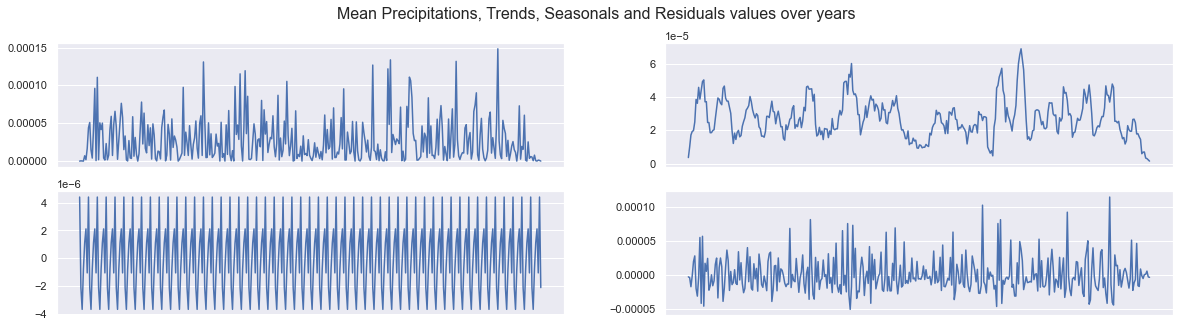

In [57]:
analysis = df_mean['prec'].copy()

decompose_result_mult = seasonal_decompose(analysis, model="additive")

trend_mean = decompose_result_mult.trend
seasonal_mean = decompose_result_mult.seasonal
residuals_mean = decompose_result_mult.resid

figure, axis = plt.subplots(2, 2)
figure.set_size_inches(20,5)
figure.suptitle('Mean Precipitations, Trends, Seasonals and Residuals values over years', fontsize=16)
axis[0,0].plot(df_mean)
axis[0,1].plot(trend_mean)
axis[1,0].plot(seasonal_mean)
axis[1,1].plot(residuals_mean)
axis[0,0].set_xticks([])
axis[0,1].set_xticks([])
axis[1,0].set_xticks([])
axis[1,1].set_xticks([])

plt.show()

## Data Correlations

This section shows some statistical analysis that can retrieve important information about the behavior of time series related to one or more features. According to our analysis, we need to consider only river locations and ignore the approximation given by coordinates that do not hit the river surface (approximately in the distance greater than 2.5 km).

In [35]:
rivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1518594 entries, 18980 to 2719979
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   time       1518594 non-null  datetime64[ns]
 1   lat        1518594 non-null  object        
 2   lon        1518594 non-null  object        
 3   discharge  1518594 non-null  object        
 4   temp       1518594 non-null  object        
 5   prec       1518594 non-null  object        
 6   coords     1518594 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 92.7+ MB


Rivers dataset has 6 columns with non-null representations. It consists in different time series filtered by geographical location given by latitude and longitude values combinations. Discharges, temperatures and precipitations changes over time for a same location and gives a time series visualization. The latitude and longitude are duplicated in 3 different columns: 2 for single values and 1 with a pair.

In [36]:
print('Total Points: {}'.format(rivers['coords'].nunique()))
coordinates = list(set(rivers['coords'])) # we take each coordinates 1 time.

Total Points: 462


According to the previous output, we have 481 different unique points with a related time series for discharge, temperature and precipitation fields.

In [37]:
rivers['time']

18980     2011-01-01 12:00:00
18981     2011-01-02 12:00:00
18982     2011-01-03 12:00:00
18983     2011-01-04 12:00:00
18984     2011-01-05 12:00:00
                  ...        
2719975   2019-12-27 12:00:00
2719976   2019-12-28 12:00:00
2719977   2019-12-29 12:00:00
2719978   2019-12-30 12:00:00
2719979   2019-12-31 12:00:00
Name: time, Length: 1518594, dtype: datetime64[ns]

We prepare data for splitting in time and locations. We already add a column related to the combination to latitude and longitude in an unique value. So, we let only split the time. In our case, time series is already daily because every measurement is done only 1 time per day at 12:00 a.m. and we can divide the $datetime$ only on days, months and years.

In [38]:
rivers.head()

time        lat       lon  discharge      temp      prec  \
18980 2011-01-01 12:00:00  44.841927  7.619702   58.29492   5.29165       0.0   
18981 2011-01-02 12:00:00  44.841927  7.619702  56.325195  4.353876  0.000002   
18982 2011-01-03 12:00:00  44.841927  7.619702  54.467773  5.771906  0.000001   
18983 2011-01-04 12:00:00  44.841927  7.619702  52.753906  8.080682       0.0   
18984 2011-01-05 12:00:00  44.841927  7.619702  51.195312  6.497247       0.0   

                       coords  
18980  (44.841927, 7.6197023)  
18981  (44.841927, 7.6197023)  
18982  (44.841927, 7.6197023)  
18983  (44.841927, 7.6197023)  
18984  (44.841927, 7.6197023)

In [39]:
coordinates[:10]

[(45.225395, 9.065623),
 (44.950962, 8.690675),
 (45.22481, 9.002067),
 (42.084316, 12.547628),
 (44.578274, 7.9451356),
 (45.124073, 11.7957),
 (45.0442, 11.032715),
 (44.627335, 11.842756),
 (42.497784, 12.261804),
 (44.622078, 7.880634)]

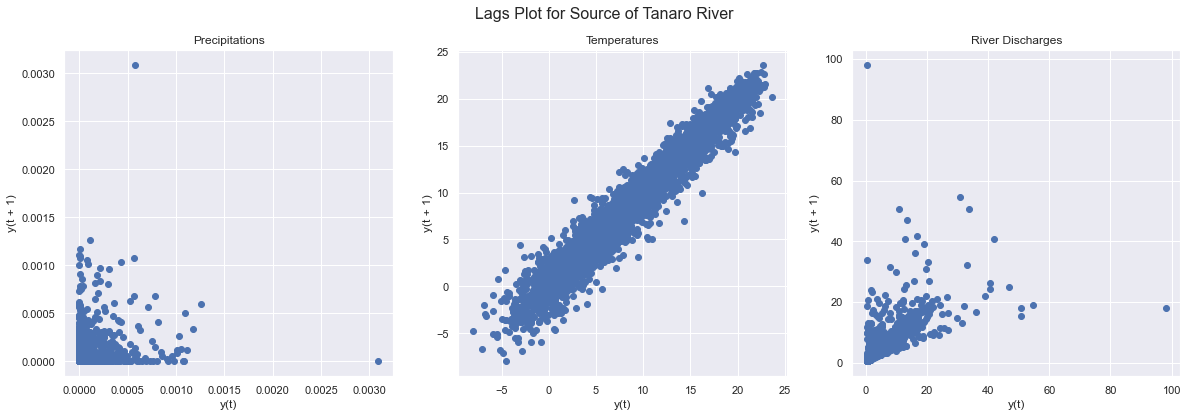

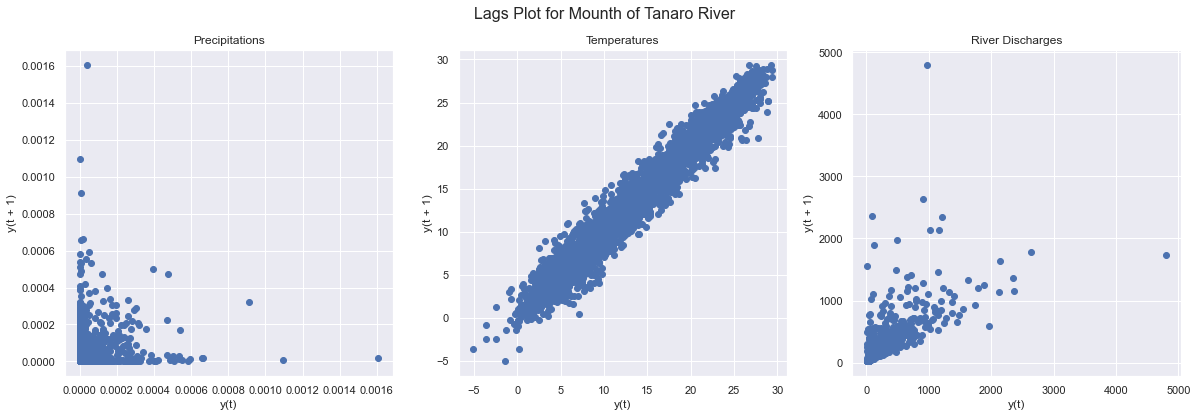

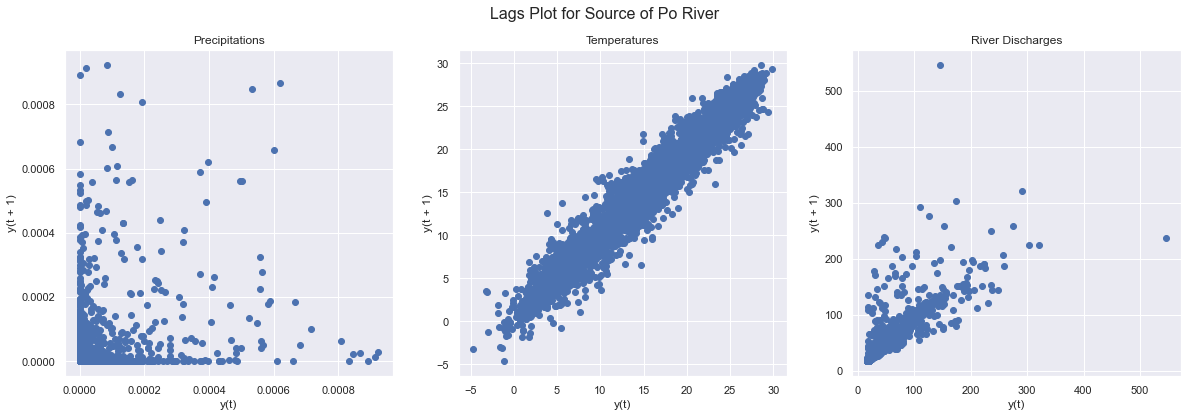

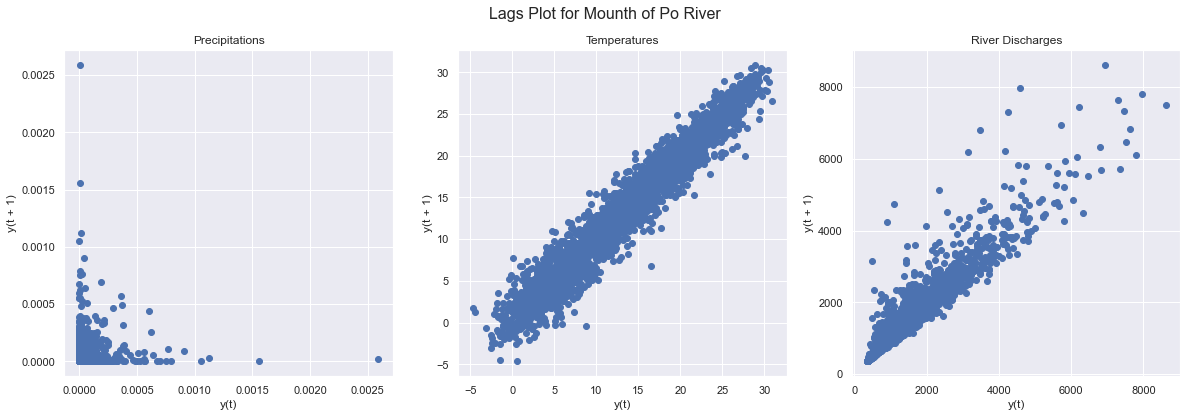

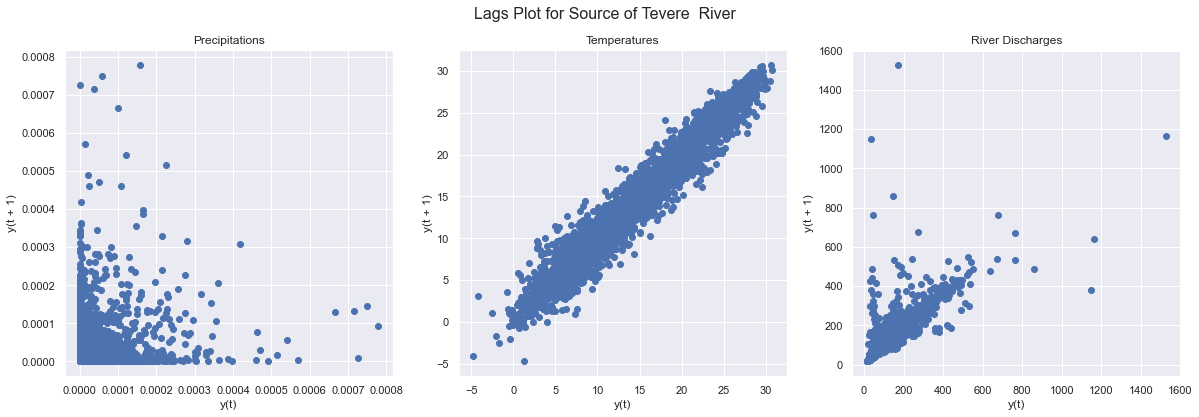

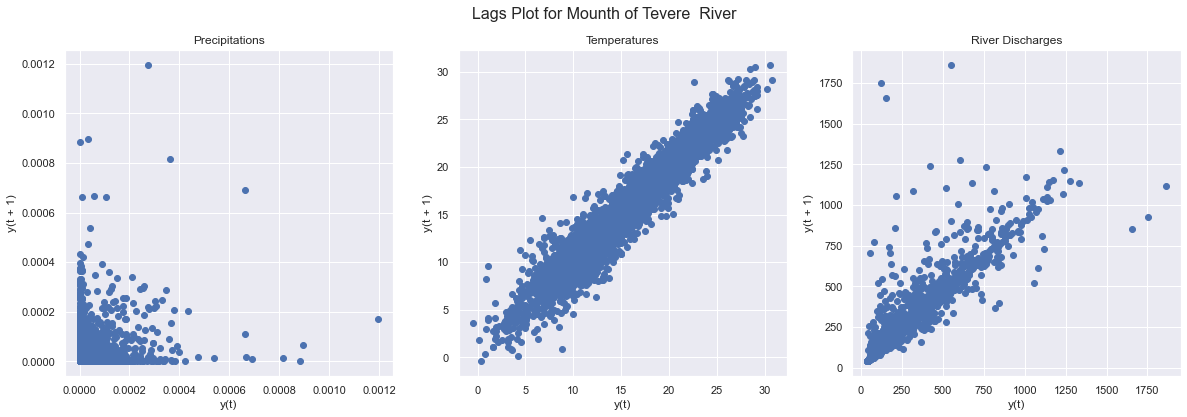

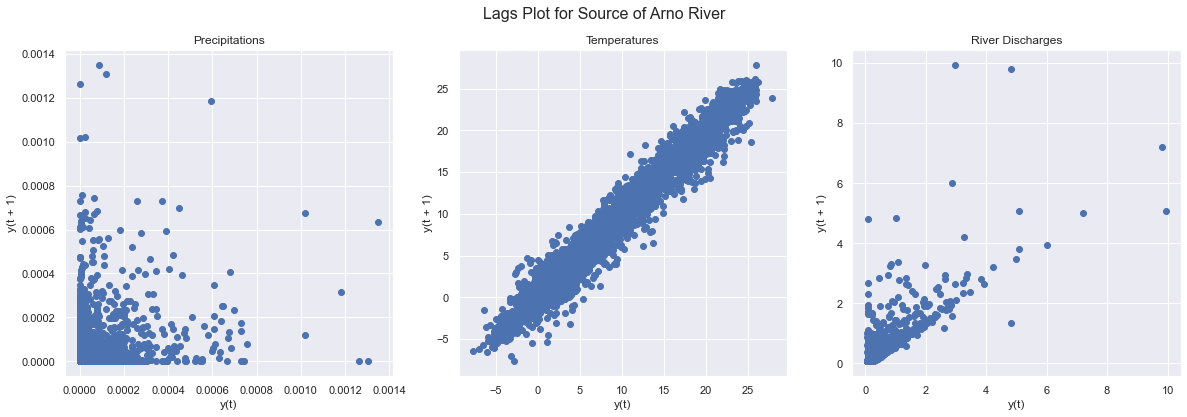

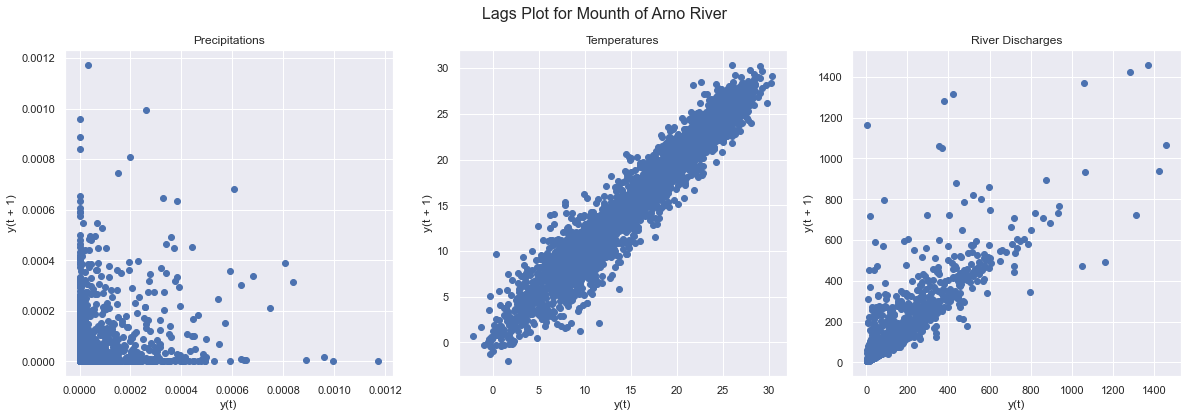

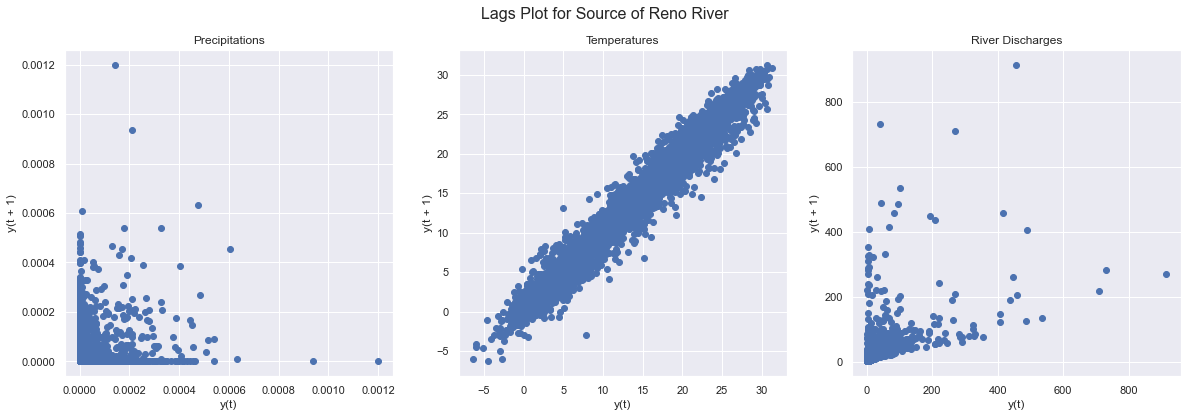

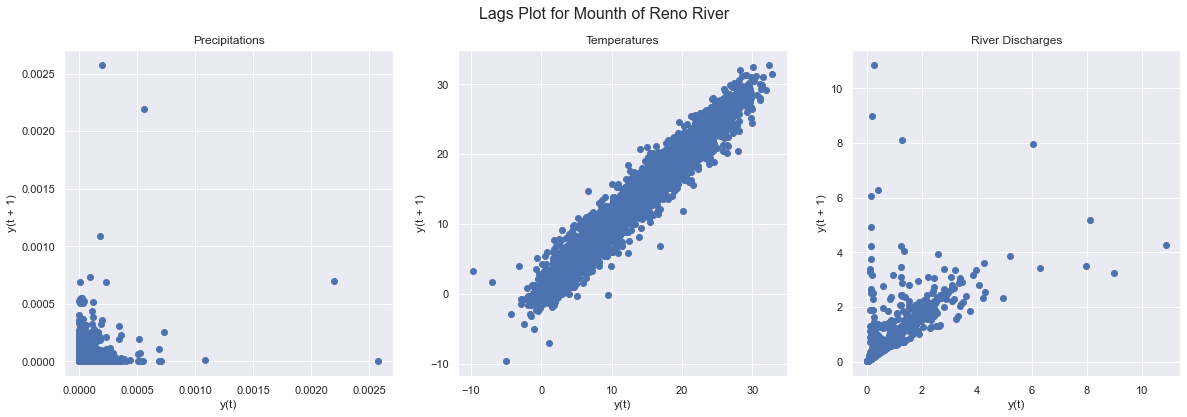

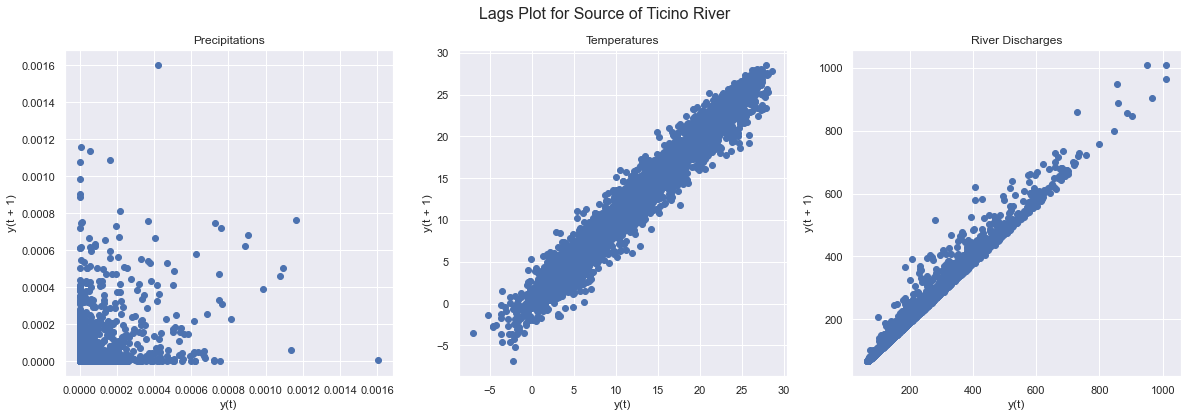

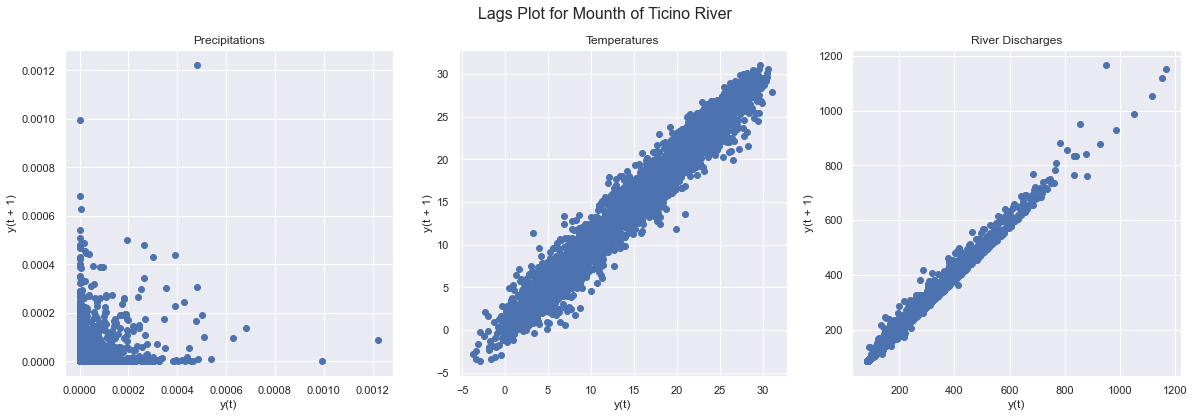

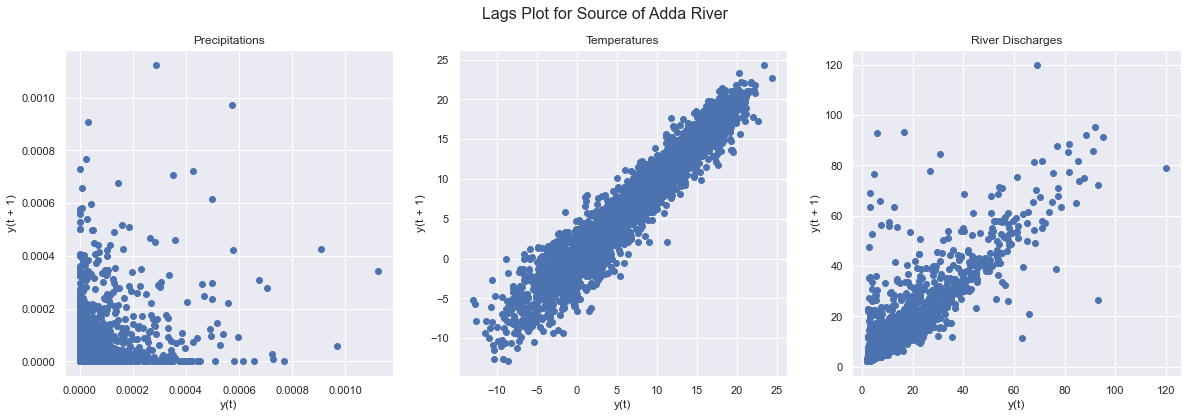

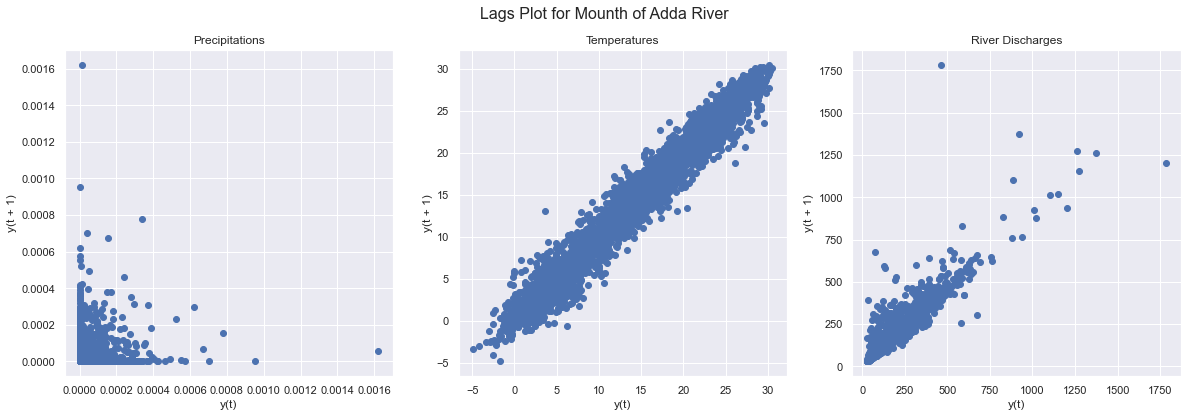

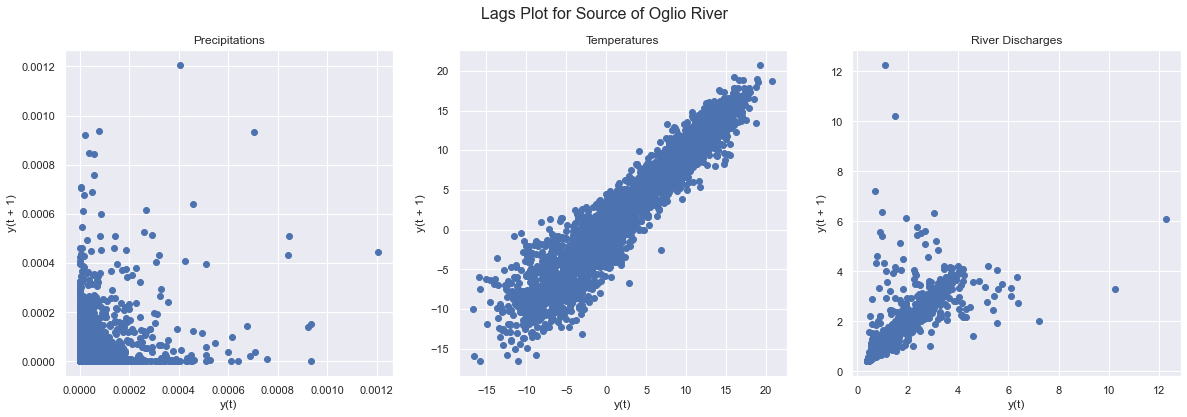

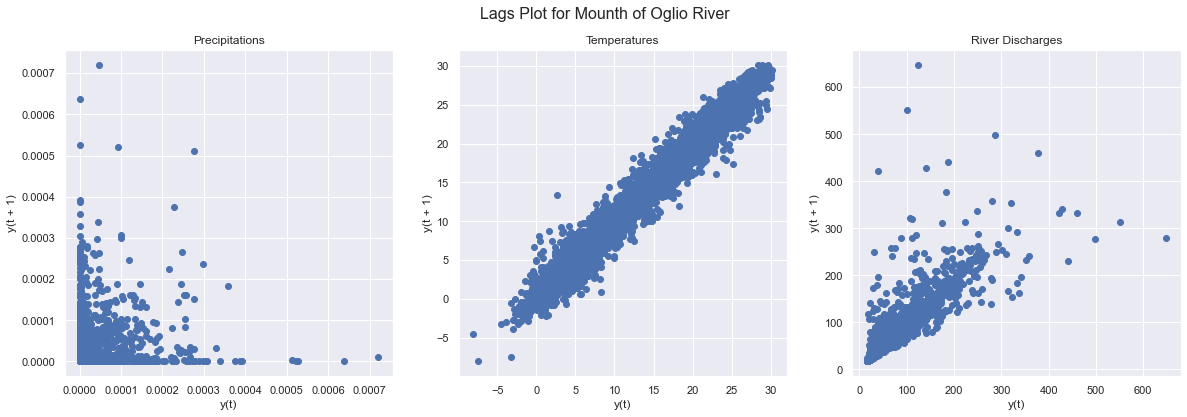

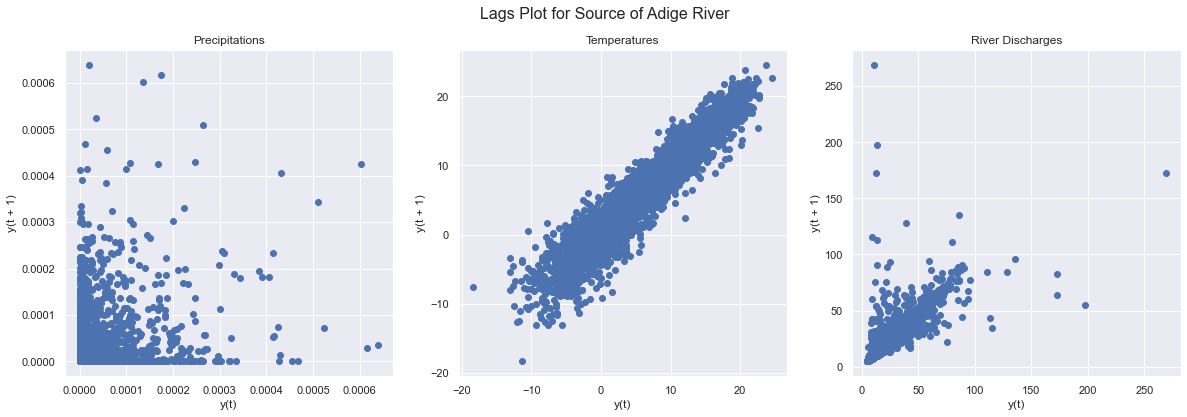

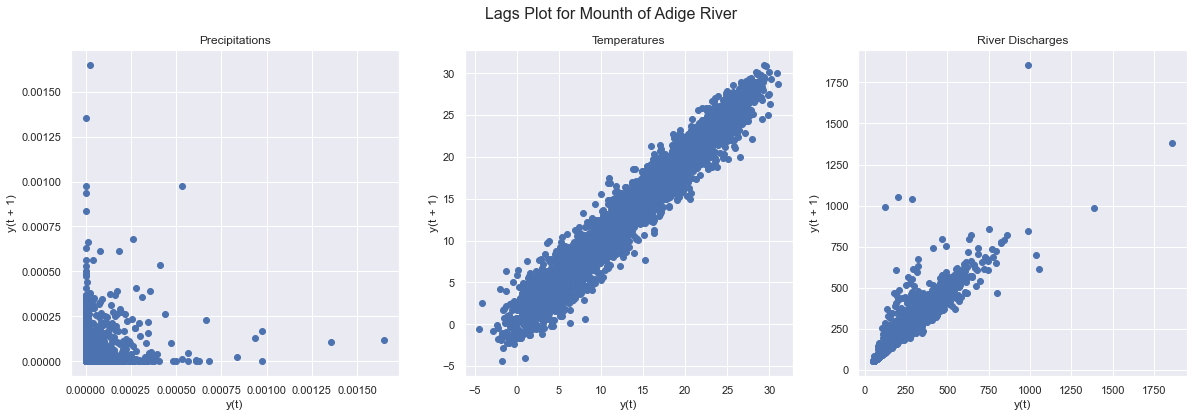

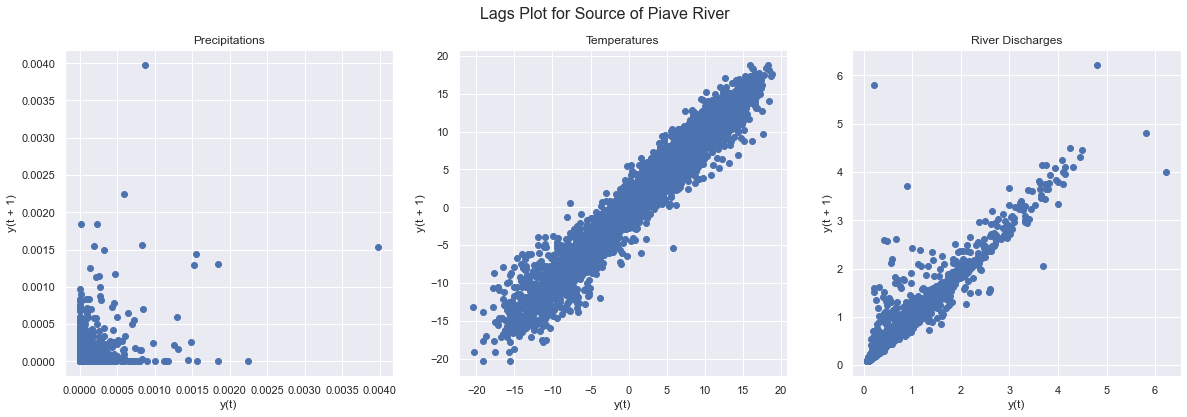

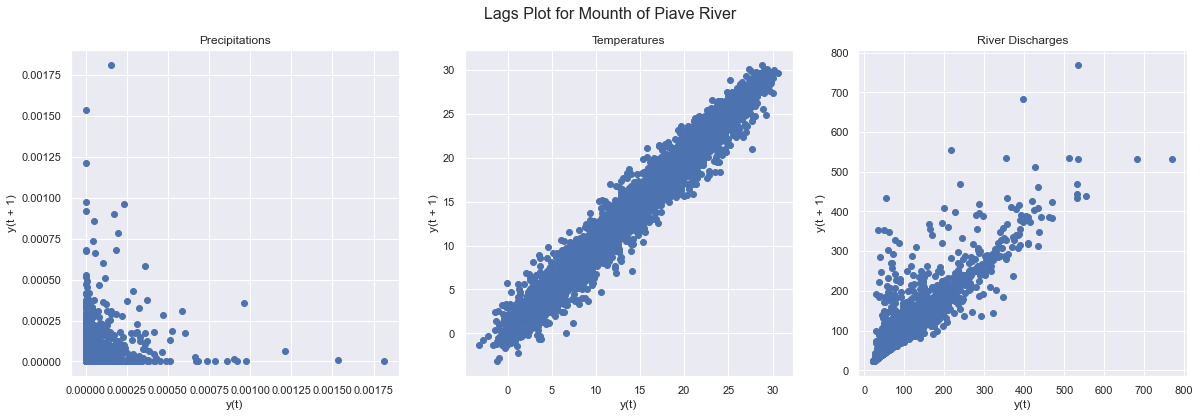

In [82]:
for key in sources.keys():

    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(20,6)
    fig.suptitle('Lags Plot for Source of {} River'.format(key), fontsize=16)
    lag_plot(sources[key]['prec'], ax=axs[0])
    axs[0].set_title('Precipitations')

    lag_plot(sources[key]['temp'], ax=axs[1])
    axs[1].set_title('Temperatures')

    lag_plot(sources[key]['discharge'], ax=axs[2])
    axs[2].set_title('River Discharges')

    fig2, axs2 = plt.subplots(1, 3)
    fig2.set_size_inches(20,6)
    fig2.suptitle('Lags Plot for Mounth of {} River'.format(key), fontsize=16)
    lag_plot(mounths[key]['prec'], ax=axs2[0])
    axs2[0].set_title('Precipitations')

    lag_plot(mounths[key]['temp'], ax=axs2[1])
    axs2[1].set_title('Temperatures')

    lag_plot(mounths[key]['discharge'], ax=axs2[2])
    axs2[2].set_title('River Discharges')

    # Hide x labels and tick labels for top plots and y ticks for right plots.


The lag plots can show if there is some autocorrelation related to the linearity of the distribution. Images belove show positive linear trends for temperature and discharge, and this should be an observation related to positive autocorrelations for these features.

## Augmented Dickey-Fuller Tests

Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not. It is one of the most commonly used statistical test when it comes to analyzing the stationary of a series. So, we can use it to test the stationary for the temperatures, precipitations and discharges on the selected samples.

In [117]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
def advanced_dfuller(data, key : str, type : str, loc : str):
    try:
        type_d = np.array(data[key][type])
        results = adfuller(type_d)
        row = pd.DataFrame()
        row['river'] = [key]
        row['loc'] = [loc]
        row['type'] = [type]
        row['adf_statistics'] = results[0]
        row['p_value'] = results[1]
        if results[1] < 0.05:
            row['h0'] = ['rejected']
            row['series'] = ['stationary']
        else:
            row['h0'] = ['accepted']
            row['series'] = ['not stationary']
        for key, value in result[4].items():
            row['crit_{}'.format(key)] = value
        return row
    except:
        print('input or key error')
        return None

adf_df = pd.DataFrame()
rows = []
for key in sources.keys():
    for type in ['discharge', 'prec', 'temp']:
        rows.append(advanced_dfuller(sources, key, type, 'source'))
        rows.append(advanced_dfuller(mounths, key, type, 'mounth'))

for row in rows:    
    adf_df = pd.concat([row, adf_df], axis=0)
adf_df.set_index(['river', 'loc'])
for key in sources.keys():
    for type in ['source', 'mounth']:
        temp = pd.DataFrame()
        temp = adf_df.copy(deep=True)
        temp = adf_df[adf_df['river'] == key]
        temp = temp[temp['loc'] == type]
        temp = temp.drop(columns=['river', 'loc'])
        temp = temp.set_index('type')
        print('ADF on {} River in {} Location:'.format(key, type))
        print(temp.head())
        print('-'*40)


ADF on Tanaro River in source Location:
           adf_statistics       p_value        h0      series   crit_1%  \
type                                                                      
temp            -3.210524  1.938354e-02  rejected  stationary -3.432349   
prec           -17.111024  7.365509e-30  rejected  stationary -3.432349   
discharge       -5.962068  2.027976e-07  rejected  stationary -3.432349   

            crit_5%  crit_10%  
type                           
temp      -2.862423  -2.56724  
prec      -2.862423  -2.56724  
discharge -2.862423  -2.56724  
----------------------------------------
ADF on Tanaro River in mounth Location:
           adf_statistics       p_value        h0      series   crit_1%  \
type                                                                      
temp            -3.085226  2.766604e-02  rejected  stationary -3.432349   
prec           -16.690653  1.489486e-29  rejected  stationary -3.432349   
discharge       -8.134079  1.070844e-12  re

ADF is a significant test based on Unit Root categories. The ADf expands the Dickey-Fuller Test including high order regressive process in the model. 

$ y_t = c + \beta t + \alpha y_{t-1} + \Theta_{1} \Lambda Y_{t-1} + \Theta_{2} \Lambda Y_{t-2}...+ \Theta_{p} \Lambda Y_{t-p} + e_t$ ; $ p \in [1..t] $ 

The Dickey-Fuller test has a null hypothesis of the existence of the unit root that can make the time series not stationary, which is equal to that $ \alpha = 1 $ in the previous equation. In our cases, every river rejects the null hypothesis, so we can affirm that discharges, temperatures and precipitations are stationary.

## KPSS Test 

Alternatively to the Augmented Dickey-Fuller test, the KPSS Test has a null hypothesis that confirms the stationary. So, we should reject the null hypothesis and accept the alternative one to determine the correct observation.

In [ ]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
def kpss_test(data, key : str, type : str, loc : str):
    try:
        type_d = np.array(data[key][type])
        results = adfuller(type_d)
        row = pd.DataFrame()
        row['river'] = [key]
        row['loc'] = [loc]
        row['type'] = [type]
        row['adf_statistics'] = results[0]
        row['p_value'] = results[1]
        if results[1] < 0.05:
            row['h0'] = ['rejected']
            row['series'] = ['stationary']
        else:
            row['h0'] = ['accepted']
            row['series'] = ['not stationary']
        for key, value in result[4].items():
            row['crit_{}'.format(key)] = value
        return row
    except:
        print('input or key error')
        return None

adf_df = pd.DataFrame()
rows = []
for key in sources.keys():
    for type in ['discharge', 'prec', 'temp']:
        rows.append(advanced_dfuller(sources, key, type, 'source'))
        rows.append(advanced_dfuller(mounths, key, type, 'mounth'))

for row in rows:    
    adf_df = pd.concat([row, adf_df], axis=0)
adf_df.set_index(['river', 'loc'])
for key in sources.keys():
    for type in ['source', 'mounth']:
        temp = pd.DataFrame()
        temp = adf_df.copy(deep=True)
        temp = adf_df[adf_df['river'] == key]
        temp = temp[temp['loc'] == type]
        temp = temp.drop(columns=['river', 'loc'])
        temp = temp.set_index('type')
        print('ADF on {} River in {} Location:'.format(key, type))
        print(temp.head())
        print('-'*40)


In [158]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
def kpss_test(series, key : str, type : str, loc : str, diff=False,  **kw):    
    if diff:
        data = series[key][type].diff().dropna()
    else:
        data = series[key][type]
    statistic, p_value, n_lags, critical_values = kpss(data, **kw)
    # Format Output
    row = pd.DataFrame()
    row['river'] = [key]
    row['type'] = [type]
    row['loc'] = [loc]
    row['statistic'] = [statistic]
    row['p_value'] = [p_value]
    row['n_lags'] = n_lags
    for key, value in critical_values.items():
        row['critic_{}'.format(key)] = value
    if p_value < 0.05:
        row['series'] = ['not stationary']
    else:
        row['series'] = ['stationary']
    return row

kpss_df = pd.DataFrame()
rows = []
for key in sources.keys():
    for type in ['discharge', 'prec', 'temp']:
        rows.append(kpss_test(sources, key, type, 'source'))
        rows.append(kpss_test(mounths, key, type, 'mounth'))

for row in rows:    
    kpss_df = pd.concat([row, kpss_df], axis=0)
kpss_df.set_index(['river', 'loc'])
for key in sources.keys():
    for type in ['source', 'mounth']:
        temp = pd.DataFrame()
        temp = kpss_df.copy(deep=True)
        temp = kpss_df[kpss_df['river'] == key]
        temp = temp[temp['loc'] == type]
        temp = temp.drop(columns=['river', 'loc'])
        temp = temp.set_index('type')
        print('KPSS on {} River in {} Location:'.format(key, type))
        print(temp.head())
        print('-'*40)

KPSS on Tanaro River in source Location:
           statistic  p_value  n_lags  critic_10%  critic_5%  critic_2.5%  \
type                                                                        
temp        0.098632  0.10000      36       0.347      0.463        0.574   
prec        0.204303  0.10000      15       0.347      0.463        0.574   
discharge   0.370061  0.09006      34       0.347      0.463        0.574   

           critic_1%      series  
type                              
temp           0.739  stationary  
prec           0.739  stationary  
discharge      0.739  stationary  
----------------------------------------
KPSS on Tanaro River in mounth Location:
           statistic  p_value  n_lags  critic_10%  critic_5%  critic_2.5%  \
type                                                                        
temp        0.076827      0.1      36       0.347      0.463        0.574   
prec        0.111841      0.1      18       0.347      0.463        0.574   
discharg

## Granger Causality

In [138]:
sources['Po']

lat       lon  discharge      temp      prec  \
time                                                                      
2011-01-01 12:00:00  44.841927  7.619702   58.29492   5.29165       0.0   
2011-01-02 12:00:00  44.841927  7.619702  56.325195  4.353876  0.000002   
2011-01-03 12:00:00  44.841927  7.619702  54.467773  5.771906  0.000001   
2011-01-04 12:00:00  44.841927  7.619702  52.753906  8.080682       0.0   
2011-01-05 12:00:00  44.841927  7.619702  51.195312  6.497247       0.0   
...                        ...       ...        ...       ...       ...   
2019-12-27 12:00:00  44.841927  7.619702  60.987793  2.406305       0.0   
2019-12-28 12:00:00  44.841927  7.619702   58.20508  2.389429       0.0   
2019-12-29 12:00:00  44.841927  7.619702  55.794434  4.538965  0.000046   
2019-12-30 12:00:00  44.841927  7.619702   53.71338   6.14306  0.000097   
2019-12-31 12:00:00  44.841927  7.619702   51.90381  6.343408  0.000007   

                                     coords  
time                                         
2011-01-01 12:00:00  (44.841927, 7.6197023)  
2011-01-02 12:00:00  (44.841927, 7.6197023)  
2011-01-03 12:00:00  (44.841927, 7.6197023)  
2011-01-04 12:00:00  (44.841927, 7.6197023)  
2011-01-05 12:00:00  (44.841927, 7.6197023)  
...                                     ...  
2019-12-27 12:00:00  (44.841927, 7.6197023)  
2019-12-28 12:00:00  (44.841927, 7.6197023)  
2019-12-29 12:00:00  (44.841927, 7.6197023)  
2019-12-30 12:00:00  (44.841927, 7.6197023)  
2019-12-31 12:00:00  (44.841927, 7.6197023)  

[3287 rows x 6 columns]

In [151]:
# define VAR for the best lang
import math
def bestlag(series, key, loc, maxlag):
    data = series[key].dropna()
    data = data.drop(columns=['lat', 'lon', 'coords'])
    data['discharge'] = data['discharge'].astype(np.float64)
    data['prec'] = data['prec'].astype(np.float64)
    data['temp'] = data['temp'].astype(np.float64)
    data = data.dropna()
    print('Best Lag for {} on {}'.format(key, loc))
    model = VAR(np.asarray(data))
    benchmark = math.inf # initial benchmark
    bestlag = 0
    for i in range(0, maxlag):
        result = model.fit(i)
        if result.aic < benchmark:
            benchmark = result.aic
            bestlag = i
    print('River {} on {}'.format(key, loc))
    print('Lag Order =', bestlag)
    print('AIC : ', benchmark)
    print('-'*20)
    return bestlag

lags = {}
for key in sources.keys():
    lags['source_' + key] = bestlag(sources, key, 'source', 50)
    lags['mounth_' + key] = bestlag(mounths, key, 'mounth', 50)




Best Lag for Tanaro on source
River Tanaro on source
Lag Order = 10
AIC :  -14.94822769414778
--------------------
Best Lag for Tanaro on mounth
River Tanaro on mounth
Lag Order = 10
AIC :  -8.320697444994293
--------------------
Best Lag for Po on source
River Po on source
Lag Order = 8
AIC :  -12.037408964129208
--------------------
Best Lag for Po on mounth
River Po on mounth
Lag Order = 8
AIC :  -6.555364998282006
--------------------
Best Lag for Tevere  on source
River Tevere  on source
Lag Order = 10
AIC :  -10.556241739486072
--------------------
Best Lag for Tevere  on mounth
River Tevere  on mounth
Lag Order = 9
AIC :  -9.54184459663721
--------------------
Best Lag for Arno on source
River Arno on source
Lag Order = 13
AIC :  -19.872244623374456
--------------------
Best Lag for Arno on mounth
River Arno on mounth
Lag Order = 10
AIC :  -9.30021585806404
--------------------
Best Lag for Reno on source
River Reno on source
Lag Order = 11
AIC :  -10.859429954236246
-----------

In [165]:
from statsmodels.tsa.stattools import grangercausalitytests

test = 'ssr_chi2test'
def grangers_causation_matrix(series, key, maxlag, test='ssr_chi2test', verbose=True):    
    data = series[key]
    try:
        data = series[key].dropna()
        data = data.drop(columns=['lat', 'lon', 'coords'])
        data['discharge'] = data['discharge'].astype(np.float64)
        data['prec'] = data['prec'].astype(np.float64)
        data['temp'] = data['temp'].astype(np.float64)
        data = data.dropna()
    except:
        return None
    variables = data.columns
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [162]:
sources[key].columns

Index(['lat', 'lon', 'discharge', 'temp', 'prec', 'coords'], dtype='object')

In [167]:
for key in sources.keys():
    for test in ['lrtest', 'ssr_ftest', 'ssr_chi2test']:
        # x cause y on test for the key
        print('-'*40)
        print('Granger Causality on {} River in {} location with {} test'.format(key, 'source', test))
        print(grangers_causation_matrix(sources, key, test=test, maxlag= lags['source_{}'.format(key)], verbose=False))
        print('-'*20)
        print('Granger Causality on {} River in {} location with {} test'.format(key, 'mounth', test))
        print(grangers_causation_matrix(mounths, key, test=test,maxlag= lags['mounth_{}'.format(key)],  verbose=False))

----------------------------------------
Granger Causality on Tanaro River in source location with lrtest test
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.0175  0.0000
temp_y            0.0114  1.0000  0.0121
prec_y            0.1134  0.0299  1.0000
--------------------
Granger Causality on Tanaro River in mounth location with lrtest test
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.0032  0.0001
temp_y            0.0101  1.0000  0.0000
prec_y            0.0681  0.0434  1.0000
----------------------------------------
Granger Causality on Tanaro River in source location with ssr_ftest test
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.0176  0.0000
temp_y            0.0115  1.0000  0.0122
prec_y            0.1137  0.0300  1.0000
--------------------
Granger Causality on Tanaro River in mounth location with ssr_ftest test
             discharge_x  temp_x  prec_x
discharge_y       1.0000  0.0032  0.0001
temp_y          